In [8]:
%load_ext autoreload
%autoreload 2
import sys

# instead of creating a package using setup.py or building from a docker/singularity file,
# import the sister directory of src code to be called on in notebook.
# This keeps the notebook free from code to only hold visualizations and is easier to test
# It also helps keep the state of variables clean such that cells aren't run out of order with a mysterious state
sys.path.append("..")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans

# import sklearn.cluster.hierarchical as hclust
from sklearn import preprocessing
import seaborn as sns
from sklearn.metrics import silhouette_score

from src import most_recent_mesonet_data
from src import most_recent_mesonet_time
from src import landtype_describe
from src.plotting_scripts import landtype
import os
import pandas as pd
import cartopy.crs as crs
import cartopy.feature as cfeature

In [10]:
def plurality_plot(df, geovar):
    projPC = crs.PlateCarree()
    latN = df["lat"].max() + 1
    latS = df["lat"].min() - 1
    lonW = df["lon"].max() + 1
    lonE = df["lon"].min() - 1
    cLat = (latN + latS) / 2
    cLon = (lonW + lonE) / 2
    projLcc = crs.LambertConformal(central_longitude=cLon, central_latitude=cLat)

    fig, ax = plt.subplots(
        figsize=(9, 9), subplot_kw={"projection": crs.PlateCarree()}, dpi=400
    )
    ax.set_extent([lonW, lonE, latS, latN], crs=projPC)
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle="--")
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.STATES)
    ax.xticklabels_top = False
    ax.ylabels_right = False
    ax.gridlines(
        crs=crs.PlateCarree(),
        draw_labels=True,
        linewidth=2,
        color="black",
        alpha=0.5,
        linestyle="--",
    )
    ax.scatter(
        x=df["lon"],
        y=df["lat"],
        c=df["color"],
        s=40,
        marker="o",
        edgecolor="black",
        transform=crs.PlateCarree(),
    )
    ax.set_title(f"Mesonet Site Groups {geovar}", size=16)
    ax.set_xlabel("Longitude", size=14)
    ax.set_ylabel("Latitude", size=14)
    ax.tick_params(axis="x", labelsize=12)
    ax.tick_params(axis="y", labelsize=12)
    ax.grid()

In [11]:
def plurality_plot_x(df, geovar):
    projPC = crs.PlateCarree()
    latN = df["lat_x"].max() + 1
    latS = df["lat_x"].min() - 1
    lonW = df["lon_x"].max() + 1
    lonE = df["lon_x"].min() - 1
    cLat = (latN + latS) / 2
    cLon = (lonW + lonE) / 2
    projLcc = crs.LambertConformal(central_longitude=cLon, central_latitude=cLat)

    fig, ax = plt.subplots(
        figsize=(12, 9), subplot_kw={"projection": crs.PlateCarree()}, dpi=400
    )
    ax.set_extent([lonW, lonE, latS, latN], crs=projPC)
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle="--")
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.STATES)
    ax.xticklabels_top = False
    ax.ylabels_right = False
    ax.gridlines(
        crs=crs.PlateCarree(),
        draw_labels=True,
        linewidth=2,
        color="black",
        alpha=0.5,
        linestyle="--",
    )
    ax.scatter(
        x=df["lon_x"],
        y=df["lat_x"],
        c=df["color"],
        s=40,
        marker="o",
        edgecolor="black",
        transform=crs.PlateCarree(),
    )
    ax.set_title(f"Mesonet Site Groups {geovar}", size=16)
    ax.set_xlabel("Longitude", size=14)
    ax.set_ylabel("Latitude", size=14)
    ax.tick_params(axis="x", labelsize=12)
    ax.tick_params(axis="y", labelsize=12)
    ax.grid()

In [12]:
# get lons and lats
# This will return the most recent data avail on mesonet
# this is my file path
ny_mesonet_data_path = "/home/aevans/nysm/archive/nysm/netcdf/proc/"
ok_mesonet_data_path = "/home/aevans/landtype/geoinfo.csv"

In [13]:
# create a dataframe of mesonet data ny
ny_df = most_recent_mesonet_data.current_time_mesonet_df(ny_mesonet_data_path)
ny_df = most_recent_mesonet_time.most_recent_time(ny_df, ny_mesonet_data_path)

In [14]:
df_lulc = pd.read_csv("/home/aevans/nwp_bias/src/landtype/data/buffer_10_percent.csv")
df_lulc.head()

site         11         21         22        23        24        31  \
0     1   1.962930   5.647257   1.299929  0.483068  0.109736  0.137242   
1     2   1.820203   4.007140   0.595656  0.093976  0.009168  0.090537   
2     3   0.697071   5.277453   4.213367  2.021878  0.932866  0.281350   
3     4  10.653124  11.111843  10.012464  9.876366  3.972609  0.532928   
4     5   0.649265   4.491848   1.082204  0.356723  0.039254  0.121773   

          41        42         43        52        71         81         82  \
0  29.370894  3.830164  25.780258  0.441523  0.210304  25.685135   4.069406   
1  66.349595  2.819553  11.070490  0.875577  0.462428  10.919786   0.054151   
2   7.929932  0.161303   1.428809  0.209436  0.164168   9.390256  53.911103   
3  42.712777  0.089967   0.535507  0.405427  0.511153   4.466284   0.080799   
4  28.382281  6.408126  31.918283  0.320048  0.181657  22.293917   1.908828   

          90        95 station  
0   0.417742  0.554411    ADDI  
1   0.728310  0.103430    ANDE  
2  12.363336  1.017672    BATA  
3   4.492357  0.546395    BEAC  
4   1.531475  0.314318    BELD

In [95]:
ny_df = ny_df[ny_df["station"].isin(df_lulc["station"])]

ny_df_lons = ny_df["lon"].to_list()
ny_df_lats = ny_df["lat"].to_list()

In [96]:
# exclude the categorical columns
features = df_lulc.drop(["site", "station"], axis=1)

In [97]:
features.describe()

11          21          22          23          24          31  \
count  126.000000  126.000000  126.000000  126.000000  126.000000  126.000000   
mean     6.617224    5.093585    3.297740    2.607357    2.021645    0.207434   
std     11.526810    3.677591    3.991497    5.531372    7.598882    0.276318   
min      0.039253    0.562736    0.036388    0.013753    0.000573    0.000000   
25%      0.711431    3.136340    1.099685    0.364960    0.067188    0.049829   
50%      1.605698    4.305988    2.092039    0.809985    0.167042    0.113744   
75%      5.843998    5.538619    3.819899    1.787487    0.564439    0.280926   
max     68.886431   23.291820   28.245067   33.463121   53.487473    1.841951   

               41          42          43          52          71          81  \
count  126.000000  126.000000  126.000000  126.000000  126.000000  126.000000   
mean    32.025156    6.830576    9.873951    0.694704    0.606327   13.464174   
std     16.451054    8.521825    8.964980    0.565298    0.637150    9.703226   
min      0.384202    0.007449    0.014612    0.051857    0.054152    0.002865   
25%     19.670130    1.335821    2.551325    0.349902    0.271267    5.608782   
50%     32.543153    3.241939    7.811640    0.516432    0.446523   13.412459   
75%     42.825779    9.857389   13.802640    0.935231    0.719396   20.191105   
max     69.827976   43.880817   47.277676    3.716915    5.670260   42.595553   

               82          90          95  
count  126.000000  126.000000  126.000000  
mean     8.093126    7.684473    0.882529  
std     12.764721    5.990246    0.966943  
min      0.000000    0.264157    0.047849  
25%      0.202279    3.010169    0.390588  
50%      2.745421    6.877554    0.615283  
75%      8.637331   11.034116    1.146611  
max     57.047361   33.070332    9.229526

In [98]:
# noramalize data
scaler = preprocessing.MinMaxScaler()
features_normal = scaler.fit_transform(features)

In [99]:
pd.DataFrame(features_normal).describe()

0           1           2           3           4           5   \
count  126.000000  126.000000  126.000000  126.000000  126.000000  126.000000   
mean     0.095545    0.199341    0.115615    0.077538    0.037786    0.112616   
std      0.167426    0.161801    0.141499    0.165366    0.142070    0.150014   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.009763    0.113230    0.037694    0.010500    0.001245    0.027052   
50%      0.022752    0.164690    0.072873    0.023804    0.003112    0.061752   
75%      0.084313    0.218921    0.134126    0.053027    0.010542    0.152515   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

               6           7           8           9           10          11  \
count  126.000000  126.000000  126.000000  126.000000  126.000000  126.000000   
mean     0.455634    0.155519    0.208606    0.175399    0.098320    0.316047   
std      0.236897    0.194237    0.189683    0.154240    0.113450    0.227814   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.277720    0.030277    0.053672    0.081320    0.038659    0.131617   
50%      0.463093    0.073723    0.164971    0.126758    0.069865    0.314833   
75%      0.611165    0.224508    0.291729    0.241026    0.118453    0.473984   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

               12          13          14  
count  126.000000  126.000000  126.000000  
mean     0.141867    0.226187    0.090907  
std      0.223757    0.182595    0.105312  
min      0.000000    0.000000    0.000000  
25%      0.003546    0.083704    0.037329  
50%      0.048125    0.201590    0.061801  
75%      0.151406    0.328291    0.119669  
max      1.000000    1.000000    1.000000

In [100]:
# kmeans clustering
inertia = []
K = range(1, 20)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(features_normal)
    kmeanModel.fit(features_normal)
    inertia.append(kmeanModel.inertia_)

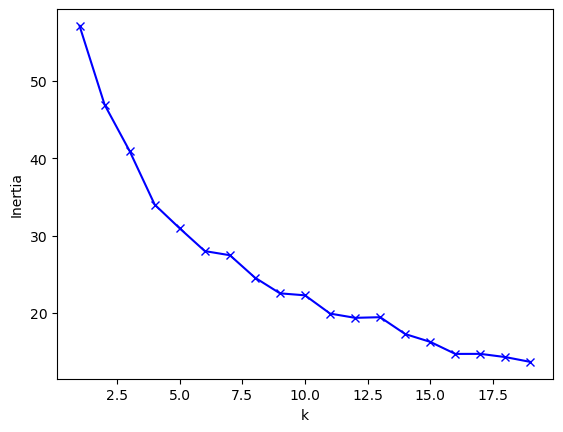

In [101]:
# Plot the elbow
plt.plot(K, inertia, "bx-")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.show()

In [102]:
# let's say our elbow is 12
kmeans = KMeans(n_clusters=7).fit(features_normal)

In [103]:
labels = pd.DataFrame(
    kmeans.labels_
)  # This is where the label output of the KMeans we just ran lives. Make it a dataframe so we can concatenate back to the original data
labeledClasses = pd.concat((features, labels), axis=1)
labeledClasses = labeledClasses.rename({0: "labels"}, axis=1)

In [104]:
labeledClasses["labels"].isna()

0      False
1      False
2      False
3      False
4      False
5      False
6      False
7      False
8      False
9      False
10     False
11     False
12     False
13     False
14     False
15     False
16     False
17     False
18     False
19     False
20     False
21     False
22     False
23     False
24     False
25     False
26     False
27     False
28     False
29     False
30     False
31     False
32     False
33     False
34     False
35     False
36     False
37     False
38     False
39     False
40     False
41     False
42     False
43     False
44     False
45     False
46     False
47     False
48     False
49     False
50     False
51     False
52     False
53     False
54     False
55     False
56     False
57     False
58     False
59     False
60     False
61     False
62     False
63     False
64     False
65     False
66     False
67     False
68     False
69     False
70     False
71     False
72     False
73     False
74     False
75     False
76     False

In [105]:
# sns.pairplot(labeledClasses, hue="labels")

In [106]:
labeledClasses[
    "Constant"
] = "Data"  # This is just to add something constant for the strip/swarm plots' X axis. Can be anything you want it to be.

In [107]:
# f, axes = plt.subplots(
#     4, 5, figsize=(20, 25), sharex=False
# )  # create a 4x5 grid of empty figures where we will plot our feature plots. We will have a couple empty ones.
# f.subplots_adjust(hspace=0.2, wspace=0.7)  # Scooch em apart, give em some room
# # In this for loop, I step through every column that I want to plot. This is a 4x5 grid, so I split this up by rows of 5 in the else if statements
# for i in range(
#     0, len(list(labeledClasses)) - 2
# ):  # minus two because I don't want to plot labels or constant
#     col = labeledClasses.columns[i]
#     if i < 5:
#         ax = sns.stripplot(
#             x=labeledClasses["Constant"],
#             y=labeledClasses[col].values,
#             hue=labeledClasses["labels"],
#             jitter=True,
#             ax=axes[0, (i)],
#         )
#         ax.set_title(col)
#     elif i >= 5 and i < 10:
#         ax = sns.stripplot(
#             x=labeledClasses["Constant"],
#             y=labeledClasses[col].values,
#             hue=labeledClasses["labels"],
#             jitter=True,
#             ax=axes[1, (i - 5)],
#         )  # so if i=6 it is row 1 column 1
#         ax.set_title(col)
#     elif i >= 10 and i < 15:
#         ax = sns.stripplot(
#             x=labeledClasses["Constant"],
#             y=labeledClasses[col].values,
#             hue=labeledClasses["labels"],
#             jitter=True,
#             ax=axes[2, (i - 10)],
#         )
#         ax.set_title(col)
#     elif i >= 15:
#         ax = sns.stripplot(
#             x=labeledClasses["Constant"],
#             y=labeledClasses[col].values,
#             hue=labeledClasses["labels"],
#             jitter=True,
#             ax=axes[3, (i - 15)],
#         )
#         ax.set_title(col)

In [108]:
# f, axes = plt.subplots(4, 5, figsize=(20, 25), sharex=False)
# f.subplots_adjust(hspace=0.2, wspace=0.7)
# for i in range(0, len(list(labeledClasses)) - 2):
#     col = labeledClasses.columns[i]
#     if i < 5:
#         ax = sns.swarmplot(
#             x=labeledClasses["Constant"],
#             y=labeledClasses[col].values,
#             hue=labeledClasses["labels"],
#             ax=axes[0, (i)],
#         )
#         ax.set_title(col)
#     elif i >= 5 and i < 10:
#         ax = sns.swarmplot(
#             x=labeledClasses["Constant"],
#             y=labeledClasses[col].values,
#             hue=labeledClasses["labels"],
#             ax=axes[1, (i - 5)],
#         )
#         ax.set_title(col)
#     elif i >= 10 and i < 15:
#         ax = sns.swarmplot(
#             x=labeledClasses["Constant"],
#             y=labeledClasses[col].values,
#             hue=labeledClasses["labels"],
#             ax=axes[2, (i - 10)],
#         )
#         ax.set_title(col)
#     elif i >= 15:
#         ax = sns.swarmplot(
#             x=labeledClasses["Constant"],
#             y=labeledClasses[col].values,
#             hue=labeledClasses["labels"],
#             ax=axes[3, (i - 15)],
#         )
#         ax.set_title(col)

In [109]:
len(ny_df_lons)

126

In [110]:
classes = df_lulc["station"]
classes = pd.concat((classes, labels), axis=1)
classes = classes.rename({"station": "station", 0: "Cluster"}, axis=1)
sortclasses = classes.sort_values(["station"])
pd.set_option("display.max_rows", 1000)
sortclasses["lon"] = ny_df_lons
sortclasses["lat"] = ny_df_lats

In [111]:
colors = [
    "black",
    "blue",
    "green",
    "red",
    "orange",
    "yellow",
    "white",
    "purple",
    "cyan",
    "plum",
    "coral",
    "pink",
]
legend = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

colordict = {}

for x, _ in enumerate(colors):
    colordict.update({legend[x]: colors[x]})

sortclasses["color"] = sortclasses["Cluster"].map(colordict)

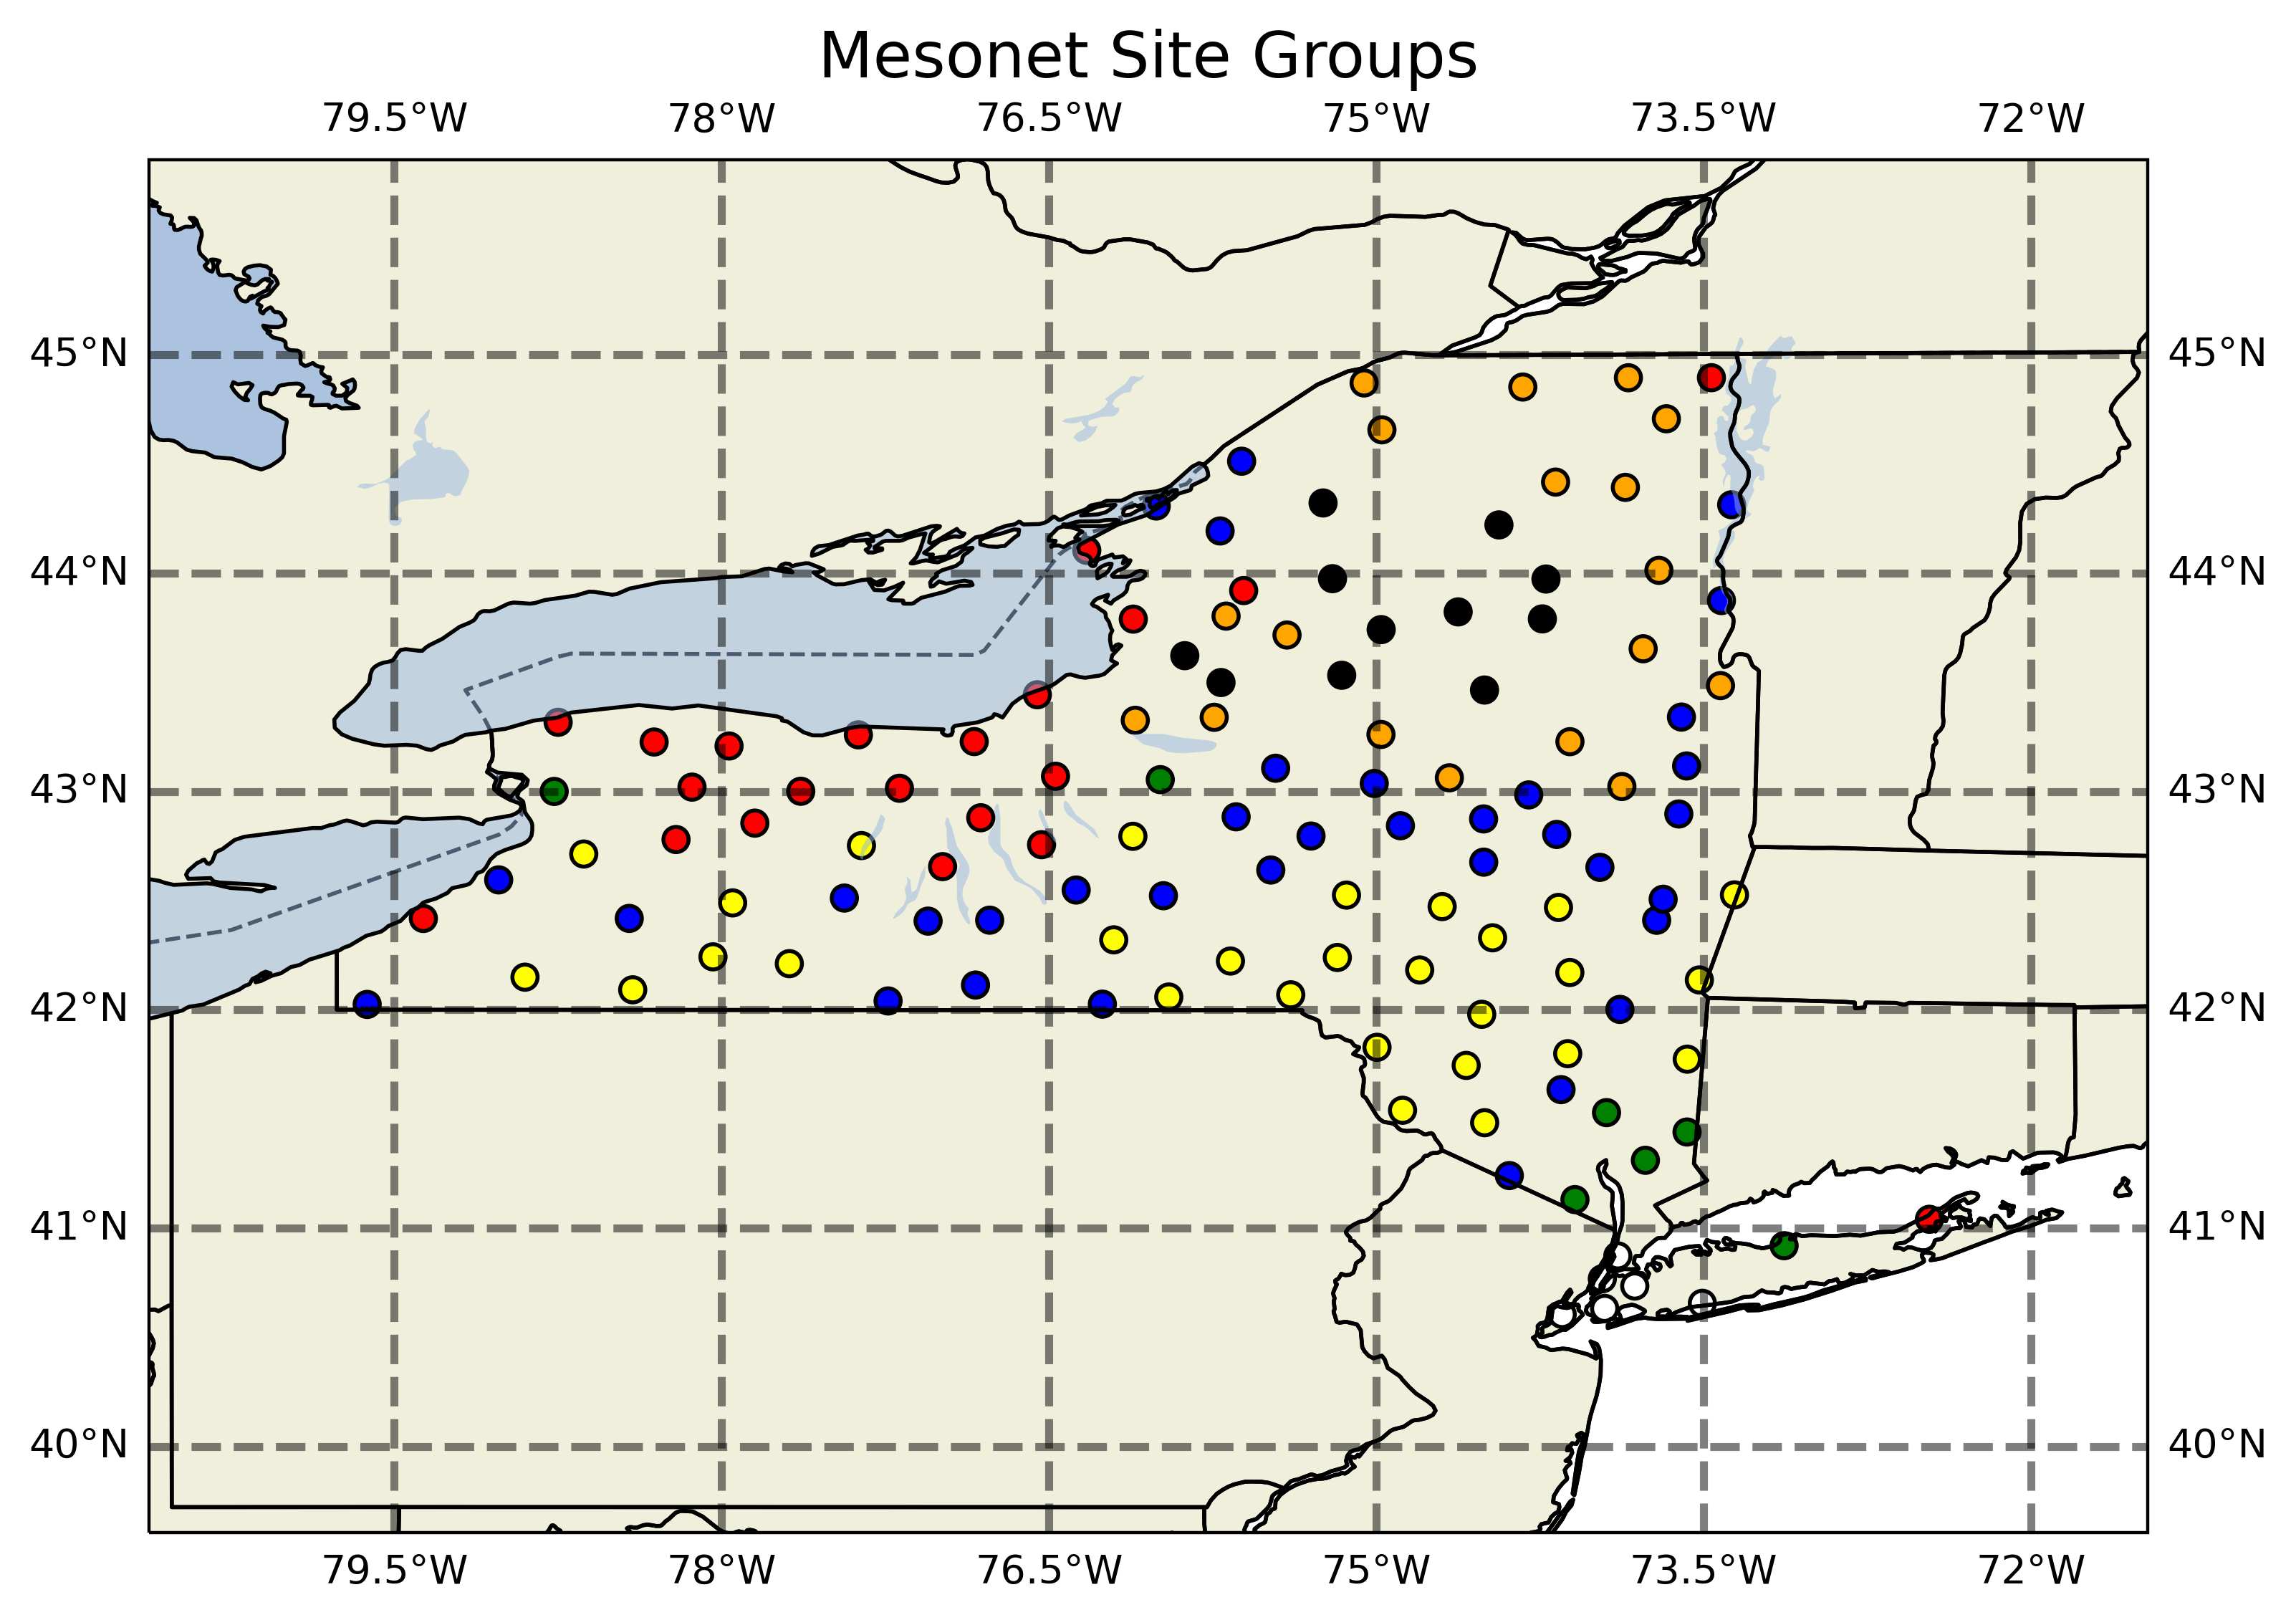

In [112]:
plurality_plot(sortclasses, "")

# Let's cluster on Elevation

In [113]:
elev_df = pd.read_csv(
    "/home/aevans/nwp_bias/src/landtype/elevation/data/NY/elev/ny30_df.csv"
)
elev_df.head()

Unnamed: 0 station      elev         std      variance      skew  \
0           0    ADDI  507.6140   78.927280   6227.304936 -0.137953   
1           1    ANDE  518.2820  114.446243  13093.302806  0.554366   
2           2    BATA  276.1200   81.741875   6679.365616  1.134595   
3           3    BEAC   90.1598   77.445227   5995.644516  0.642901   
4           4    BELD  470.3700   71.198890   5067.491291 -0.024945   

     med_dist        lon        lat  
0  533.728027 -77.237259  42.040359  
1  428.563965 -74.801392  42.182270  
2  325.239990 -78.135658  43.019939  
3   43.319595 -73.945267  41.528751  
4  520.739990 -75.668518  42.223221

In [114]:
# exclude the categorical columns
features_elev = elev_df.drop(["station", "Unnamed: 0", "lon", "lat"], axis=1)

In [115]:
# noramalize data
scaler = preprocessing.MinMaxScaler()
features_norm = scaler.fit_transform(features_elev)

In [116]:
pd.DataFrame(features_norm).describe()

0           1           2           3           4
count  126.000000  126.000000  126.000000  126.000000  126.000000
mean     0.393459    0.341613    0.166600    0.484892    0.319716
std      0.251843    0.183900    0.155111    0.165858    0.177573
min      0.000000    0.000000    0.000000    0.000000    0.000000
25%      0.166734    0.217243    0.061724    0.381392    0.178185
50%      0.356824    0.358310    0.148031    0.477097    0.275500
75%      0.607616    0.438742    0.213534    0.569033    0.441567
max      1.000000    1.000000    1.000000    1.000000    1.000000

In [117]:
# kmeans clustering
inertia_elev = []
K = range(1, 15)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(features_norm)
    kmeanModel.fit(features_norm)
    inertia_elev.append(kmeanModel.inertia_)

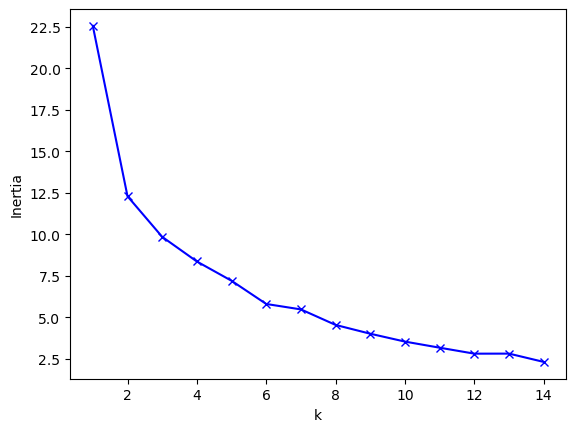

In [118]:
# Plot the elbow
plt.plot(K, inertia_elev, "bx-")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.show()

In [119]:
# let's say our elbow is 12
kmeans_elev = KMeans(n_clusters=4).fit(features_norm)

In [120]:
labels_elev = pd.DataFrame(
    kmeans_elev.labels_
)  # This is where the label output of the KMeans we just ran lives. Make it a dataframe so we can concatenate back to the original data
labeledElev = pd.concat((features_elev, labels_elev), axis=1)
labeledElev = labeledElev.rename({0: "labels"}, axis=1)

In [121]:
labeledElev.head()

elev         std      variance      skew    med_dist  labels
0  507.6140   78.927280   6227.304936 -0.137953  533.728027       2
1  518.2820  114.446243  13093.302806  0.554366  428.563965       2
2  276.1200   81.741875   6679.365616  1.134595  325.239990       1
3   90.1598   77.445227   5995.644516  0.642901   43.319595       3
4  470.3700   71.198890   5067.491291 -0.024945  520.739990       2

In [122]:
# sns.pairplot(labeledElev, hue="labels")

In [123]:
labeledElev[
    "Constant"
] = "Data"  # This is just to add something constant for the strip/swarm plots' X axis. Can be anything you want it to be.

In [124]:
# f, axes = plt.subplots(
#     4, 5, figsize=(20, 25), sharex=False
# )  # create a 4x5 grid of empty figures where we will plot our feature plots. We will have a couple empty ones.
# f.subplots_adjust(hspace=0.2, wspace=0.7)  # Scooch em apart, give em some room
# # In this for loop, I step through every column that I want to plot. This is a 4x5 grid, so I split this up by rows of 5 in the else if statements
# for i in range(
#     0, len(list(labeledElev)) - 2
# ):  # minus two because I don't want to plot labels or constant
#     col = labeledElev.columns[i]
#     if i < 5:
#         ax = sns.stripplot(
#             x=labeledElev["Constant"],
#             y=labeledElev[col].values,
#             hue=labeledElev["labels"],
#             jitter=True,
#             ax=axes[0, (i)],
#         )
#         ax.set_title(col)
#     elif i >= 5 and i < 10:
#         ax = sns.stripplot(
#             x=labeledElev["Constant"],
#             y=labeledElev[col].values,
#             hue=labeledElev["labels"],
#             jitter=True,
#             ax=axes[1, (i - 5)],
#         )  # so if i=6 it is row 1 column 1
#         ax.set_title(col)
#     elif i >= 10 and i < 15:
#         ax = sns.stripplot(
#             x=labeledElev["Constant"],
#             y=labeledElev[col].values,
#             hue=labeledElev["labels"],
#             jitter=True,
#             ax=axes[2, (i - 10)],
#         )
#         ax.set_title(col)
#     elif i >= 15:
#         ax = sns.stripplot(
#             x=labeledElev["Constant"],
#             y=labeledElev[col].values,
#             hue=labeledElev["labels"],
#             jitter=True,
#             ax=axes[3, (i - 15)],
#         )
#         ax.set_title(col)

In [125]:
# f, axes = plt.subplots(4, 5, figsize=(20, 25), sharex=False)
# f.subplots_adjust(hspace=0.2, wspace=0.7)
# for i in range(0, len(list(labeledElev)) - 2):
#     col = labeledElev.columns[i]
#     if i < 5:
#         ax = sns.swarmplot(
#             x=labeledElev["Constant"],
#             y=labeledElev[col].values,
#             hue=labeledElev["labels"],
#             ax=axes[0, (i)],
#         )
#         ax.set_title(col)
#     elif i >= 5 and i < 10:
#         ax = sns.swarmplot(
#             x=labeledElev["Constant"],
#             y=labeledElev[col].values,
#             hue=labeledElev["labels"],
#             ax=axes[1, (i - 5)],
#         )
#         ax.set_title(col)
#     elif i >= 10 and i < 15:
#         ax = sns.swarmplot(
#             x=labeledElev["Constant"],
#             y=labeledElev[col].values,
#             hue=labeledElev["labels"],
#             ax=axes[2, (i - 10)],
#         )
#         ax.set_title(col)
#     elif i >= 15:
#         ax = sns.swarmplot(
#             x=labeledElev["Constant"],
#             y=labeledElev[col].values,
#             hue=labeledElev["labels"],
#             ax=axes[3, (i - 15)],
#         )
#         ax.set_title(col)

In [126]:
elevs = df_lulc["station"]
elevs = pd.concat((elevs, labels_elev), axis=1)
elevs = elevs.rename({"station": "station", 0: "Cluster"}, axis=1)
sortelevs = elevs.sort_values(["station"])
pd.set_option("display.max_rows", 1000)
sortelevs["lon"] = ny_df_lons
sortelevs["lat"] = ny_df_lats

In [127]:
colors = [
    "black",
    "blue",
    "green",
    "red",
    "orange",
    "yellow",
    "white",
    "purple",
    "cyan",
    "plum",
    "coral",
    "pink",
]
legend = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

colordict = {}

for x, _ in enumerate(colors):
    colordict.update({legend[x]: colors[x]})

sortelevs["color"] = sortelevs["Cluster"].map(colordict)

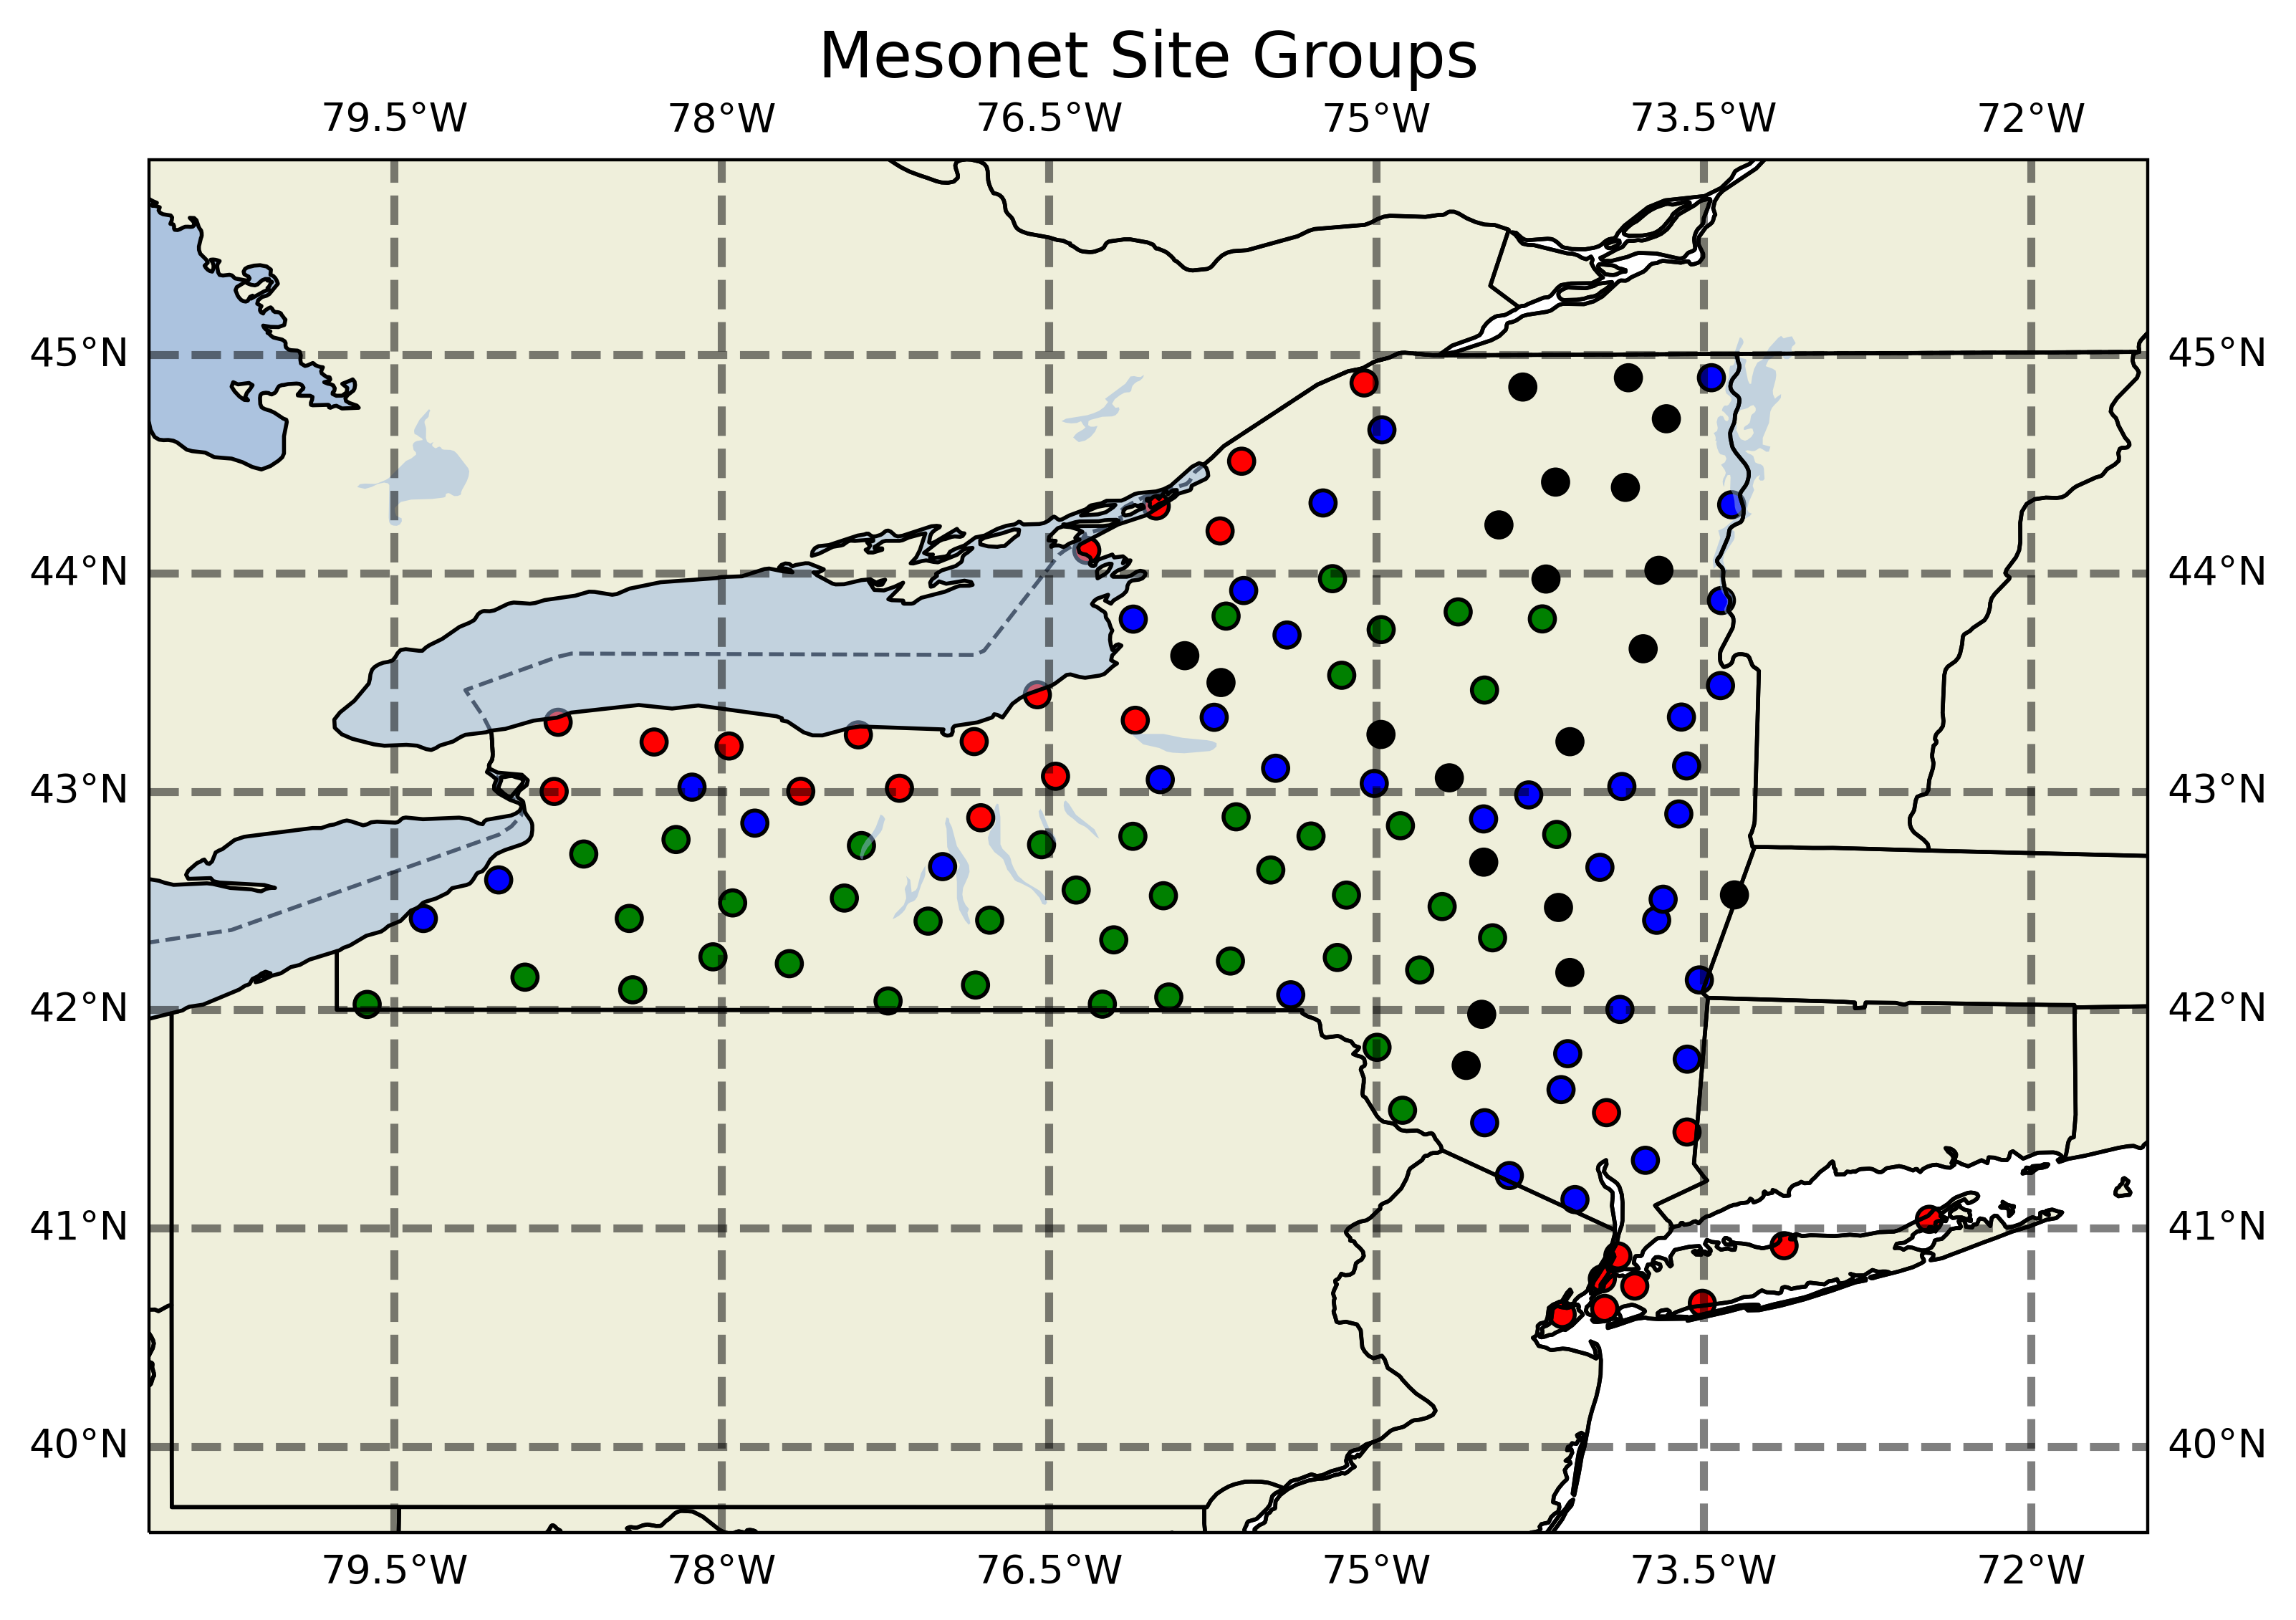

In [128]:
plurality_plot(sortelevs)

# let's cluster on slope

In [129]:
slope_df = pd.read_csv(
    "/home/aevans/nwp_bias/src/landtype/elevation/data/NY/slope/sl_percent_30.csv"
)
slope_df.head()

site         19        21        22        23        24        25  \
0     0  78.362573  2.850877  3.070175  2.521930  2.960526  1.937135   
1     1  52.497343  6.269926  3.719447  6.836699  5.419766  4.321644   
2     2  98.319942  0.000000  0.073046  0.840029  0.073046  0.000000   
3     3  87.073609  0.825853  1.077199  3.590664  1.184919  0.179533   
4     4  83.398093  1.377605  2.225362  2.366655  0.812434  1.059696   

         26        27        28   33   37   32   34   38   31   35   36  \
0  2.668129  2.558480  3.070175  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  6.269926  6.695005  7.970244  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.000000  0.438276  0.255661  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.897666  3.123878  2.046679  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  1.695514  3.708937  3.355705  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

  station  
0    ADDI  
1    ANDE  
2    BATA  
3    BEAC  
4    BELD

In [130]:
# exclude the categorical columns
features_slope = slope_df.drop(["site", "station"], axis=1)

In [131]:
# noramalize data
scaler = preprocessing.MinMaxScaler()
features_norm_sl = scaler.fit_transform(features_slope)

In [132]:
pd.DataFrame(features_norm_sl).describe()

0           1           2           3           4           5   \
count  126.000000  126.000000  126.000000  126.000000  126.000000  126.000000   
mean     0.748601    0.165735    0.204936    0.203540    0.148126    0.130909   
std      0.240722    0.198279    0.204064    0.215429    0.192802    0.193027   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.611785    0.004318    0.034661    0.022407    0.003760    0.000000   
50%      0.784605    0.104636    0.147624    0.145285    0.063645    0.064457   
75%      0.969044    0.247014    0.286698    0.310624    0.229507    0.173910   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

               6           7           8           9           10          11  \
count  126.000000  126.000000  126.000000  126.000000  126.000000  126.000000   
mean     0.206674    0.251765    0.211425    0.036591    0.038569    0.025088   
std      0.228206    0.240179    0.228522    0.147991    0.153581    0.117961   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.023261    0.004561    0.000000    0.000000    0.000000   
50%      0.137074    0.218686    0.165747    0.000000    0.000000    0.000000   
75%      0.314237    0.406743    0.321628    0.000000    0.000000    0.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

               12          13          14          15          16  
count  126.000000  126.000000  126.000000  126.000000  126.000000  
mean     0.042020    0.019902    0.026150    0.015782    0.007937  
std      0.187105    0.122688    0.134467    0.124769    0.089087  
min      0.000000    0.000000    0.000000    0.000000    0.000000  
25%      0.000000    0.000000    0.000000    0.000000    0.000000  
50%      0.000000    0.000000    0.000000    0.000000    0.000000  
75%      0.000000    0.000000    0.000000    0.000000    0.000000  
max      1.000000    1.000000    1.000000    1.000000    1.000000

In [133]:
# kmeans clustering
inertia_slope = []
K = range(1, 15)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(features_norm_sl)
    kmeanModel.fit(features_norm_sl)
    inertia_slope.append(kmeanModel.inertia_)

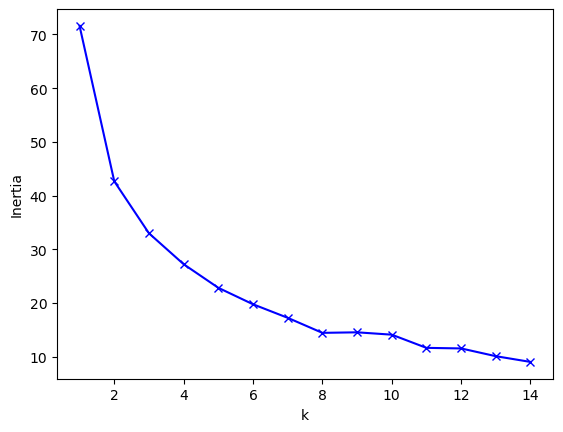

In [134]:
# Plot the elbow
plt.plot(K, inertia_slope, "bx-")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.show()

In [135]:
# let's say our elbow is 12
kmeans_slope = KMeans(n_clusters=5).fit(features_norm_sl)

In [136]:
labels_slope = pd.DataFrame(
    kmeans_slope.labels_
)  # This is where the label output of the KMeans we just ran lives. Make it a dataframe so we can concatenate back to the original data
labeledSlope = pd.concat((features_slope, labels_slope), axis=1)
labeledSlope = labeledSlope.rename({0: "labels"}, axis=1)

In [137]:
labeledSlope.head()

19        21        22        23        24        25        26  \
0  78.362573  2.850877  3.070175  2.521930  2.960526  1.937135  2.668129   
1  52.497343  6.269926  3.719447  6.836699  5.419766  4.321644  6.269926   
2  98.319942  0.000000  0.073046  0.840029  0.073046  0.000000  0.000000   
3  87.073609  0.825853  1.077199  3.590664  1.184919  0.179533  0.897666   
4  83.398093  1.377605  2.225362  2.366655  0.812434  1.059696  1.695514   

         27        28   33   37   32   34   38   31   35   36  labels  
0  2.558480  3.070175  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0       0  
1  6.695005  7.970244  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0       2  
2  0.438276  0.255661  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0       1  
3  3.123878  2.046679  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0       3  
4  3.708937  3.355705  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0       3

In [138]:
# sns.pairplot(labeledSlope, hue="labels")

In [139]:
labeledSlope[
    "Constant"
] = "Data"  # This is just to add something constant for the strip/swarm plots' X axis. Can be anything you want it to be.

In [142]:
save_df = pd.DataFrame()
save_df["station"] = ny_df["station"]
save_df.reset_index(inplace=True)
save_df["lulc_cat"] = labeledClasses["labels"]
save_df["elev_cat"] = labeledElev["labels"]
save_df["slope_cat"] = labeledSlope["labels"]

save_df.to_csv("/home/aevans/nwp_bias/src/landtype/data/lstm_clusters.csv")

In [ ]:
labeledSlope.head()

19        21        22        23        24        25        26  \
0  78.362573  2.850877  3.070175  2.521930  2.960526  1.937135  2.668129   
1  52.497343  6.269926  3.719447  6.836699  5.419766  4.321644  6.269926   
2  98.319942  0.000000  0.073046  0.840029  0.073046  0.000000  0.000000   
3  87.073609  0.825853  1.077199  3.590664  1.184919  0.179533  0.897666   
4  83.398093  1.377605  2.225362  2.366655  0.812434  1.059696  1.695514   

         27        28   33   37   32   34   38   31   35   36  labels Constant  
0  2.558480  3.070175  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0       1     Data  
1  6.695005  7.970244  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0       3     Data  
2  0.438276  0.255661  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0       0     Data  
3  3.123878  2.046679  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0       0     Data  
4  3.708937  3.355705  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0       1     Data

In [ ]:
# f, axes = plt.subplots(
#     4, 5, figsize=(20, 25), sharex=False
# )  # create a 4x5 grid of empty figures where we will plot our feature plots. We will have a couple empty ones.
# f.subplots_adjust(hspace=0.2, wspace=0.7)  # Scooch em apart, give em some room
# # In this for loop, I step through every column that I want to plot. This is a 4x5 grid, so I split this up by rows of 5 in the else if statements
# for i in range(
#     0, len(list(labeledSlope)) - 2
# ):  # minus two because I don't want to plot labels or constant
#     col = labeledSlope.columns[i]
#     if i < 5:
#         ax = sns.stripplot(
#             x=labeledSlope["Constant"],
#             y=labeledSlope[col].values,
#             hue=labeledSlope["labels"],
#             jitter=True,
#             ax=axes[0, (i)],
#         )
#         ax.set_title(col)
#     elif i >= 5 and i < 10:
#         ax = sns.stripplot(
#             x=labeledSlope["Constant"],
#             y=labeledSlope[col].values,
#             hue=labeledSlope["labels"],
#             jitter=True,
#             ax=axes[1, (i - 5)],
#         )  # so if i=6 it is row 1 column 1
#         ax.set_title(col)
#     elif i >= 10 and i < 15:
#         ax = sns.stripplot(
#             x=labeledSlope["Constant"],
#             y=labeledSlope[col].values,
#             hue=labeledSlope["labels"],
#             jitter=True,
#             ax=axes[2, (i - 10)],
#         )
#         ax.set_title(col)
#     elif i >= 15:
#         ax = sns.stripplot(
#             x=labeledSlope["Constant"],
#             y=labeledSlope[col].values,
#             hue=labeledSlope["labels"],
#             jitter=True,
#             ax=axes[3, (i - 15)],
#         )
#         ax.set_title(col)

In [ ]:
# f, axes = plt.subplots(4, 5, figsize=(20, 25), sharex=False)
# f.subplots_adjust(hspace=0.2, wspace=0.7)
# for i in range(0, len(list(labeledSlope)) - 2):
#     col = labeledSlope.columns[i]
#     if i < 5:
#         ax = sns.swarmplot(
#             x=labeledSlope["Constant"],
#             y=labeledSlope[col].values,
#             hue=labeledSlope["labels"],
#             ax=axes[0, (i)],
#         )
#         ax.set_title(col)
#     elif i >= 5 and i < 10:
#         ax = sns.swarmplot(
#             x=labeledSlope["Constant"],
#             y=labeledSlope[col].values,
#             hue=labeledSlope["labels"],
#             ax=axes[1, (i - 5)],
#         )
#         ax.set_title(col)
#     elif i >= 10 and i < 15:
#         ax = sns.swarmplot(
#             x=labeledSlope["Constant"],
#             y=labeledSlope[col].values,
#             hue=labeledSlope["labels"],
#             ax=axes[2, (i - 10)],
#         )
#         ax.set_title(col)
#     elif i >= 15:
#         ax = sns.swarmplot(
#             x=labeledSlope["Constant"],
#             y=labeledSlope[col].values,
#             hue=labeledSlope["labels"],
#             ax=axes[3, (i - 15)],
#         )
#         ax.set_title(col)

In [ ]:
slopes = df_lulc["station"]
slopes = pd.concat((slopes, labels_slope), axis=1)
slopes = slopes.rename({"station": "station", 0: "Cluster"}, axis=1)
sortslopes = slopes.sort_values(["station"])
pd.set_option("display.max_rows", 1000)
sortslopes["lon"] = ny_df_lons
sortslopes["lat"] = ny_df_lats

In [ ]:
colors = [
    "black",
    "blue",
    "green",
    "red",
    "orange",
    "yellow",
    "white",
    "purple",
    "cyan",
    "plum",
    "coral",
    "pink",
]
legend = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

colordict = {}

for x, _ in enumerate(colors):
    colordict.update({legend[x]: colors[x]})

sortslopes["color"] = sortslopes["Cluster"].map(colordict)

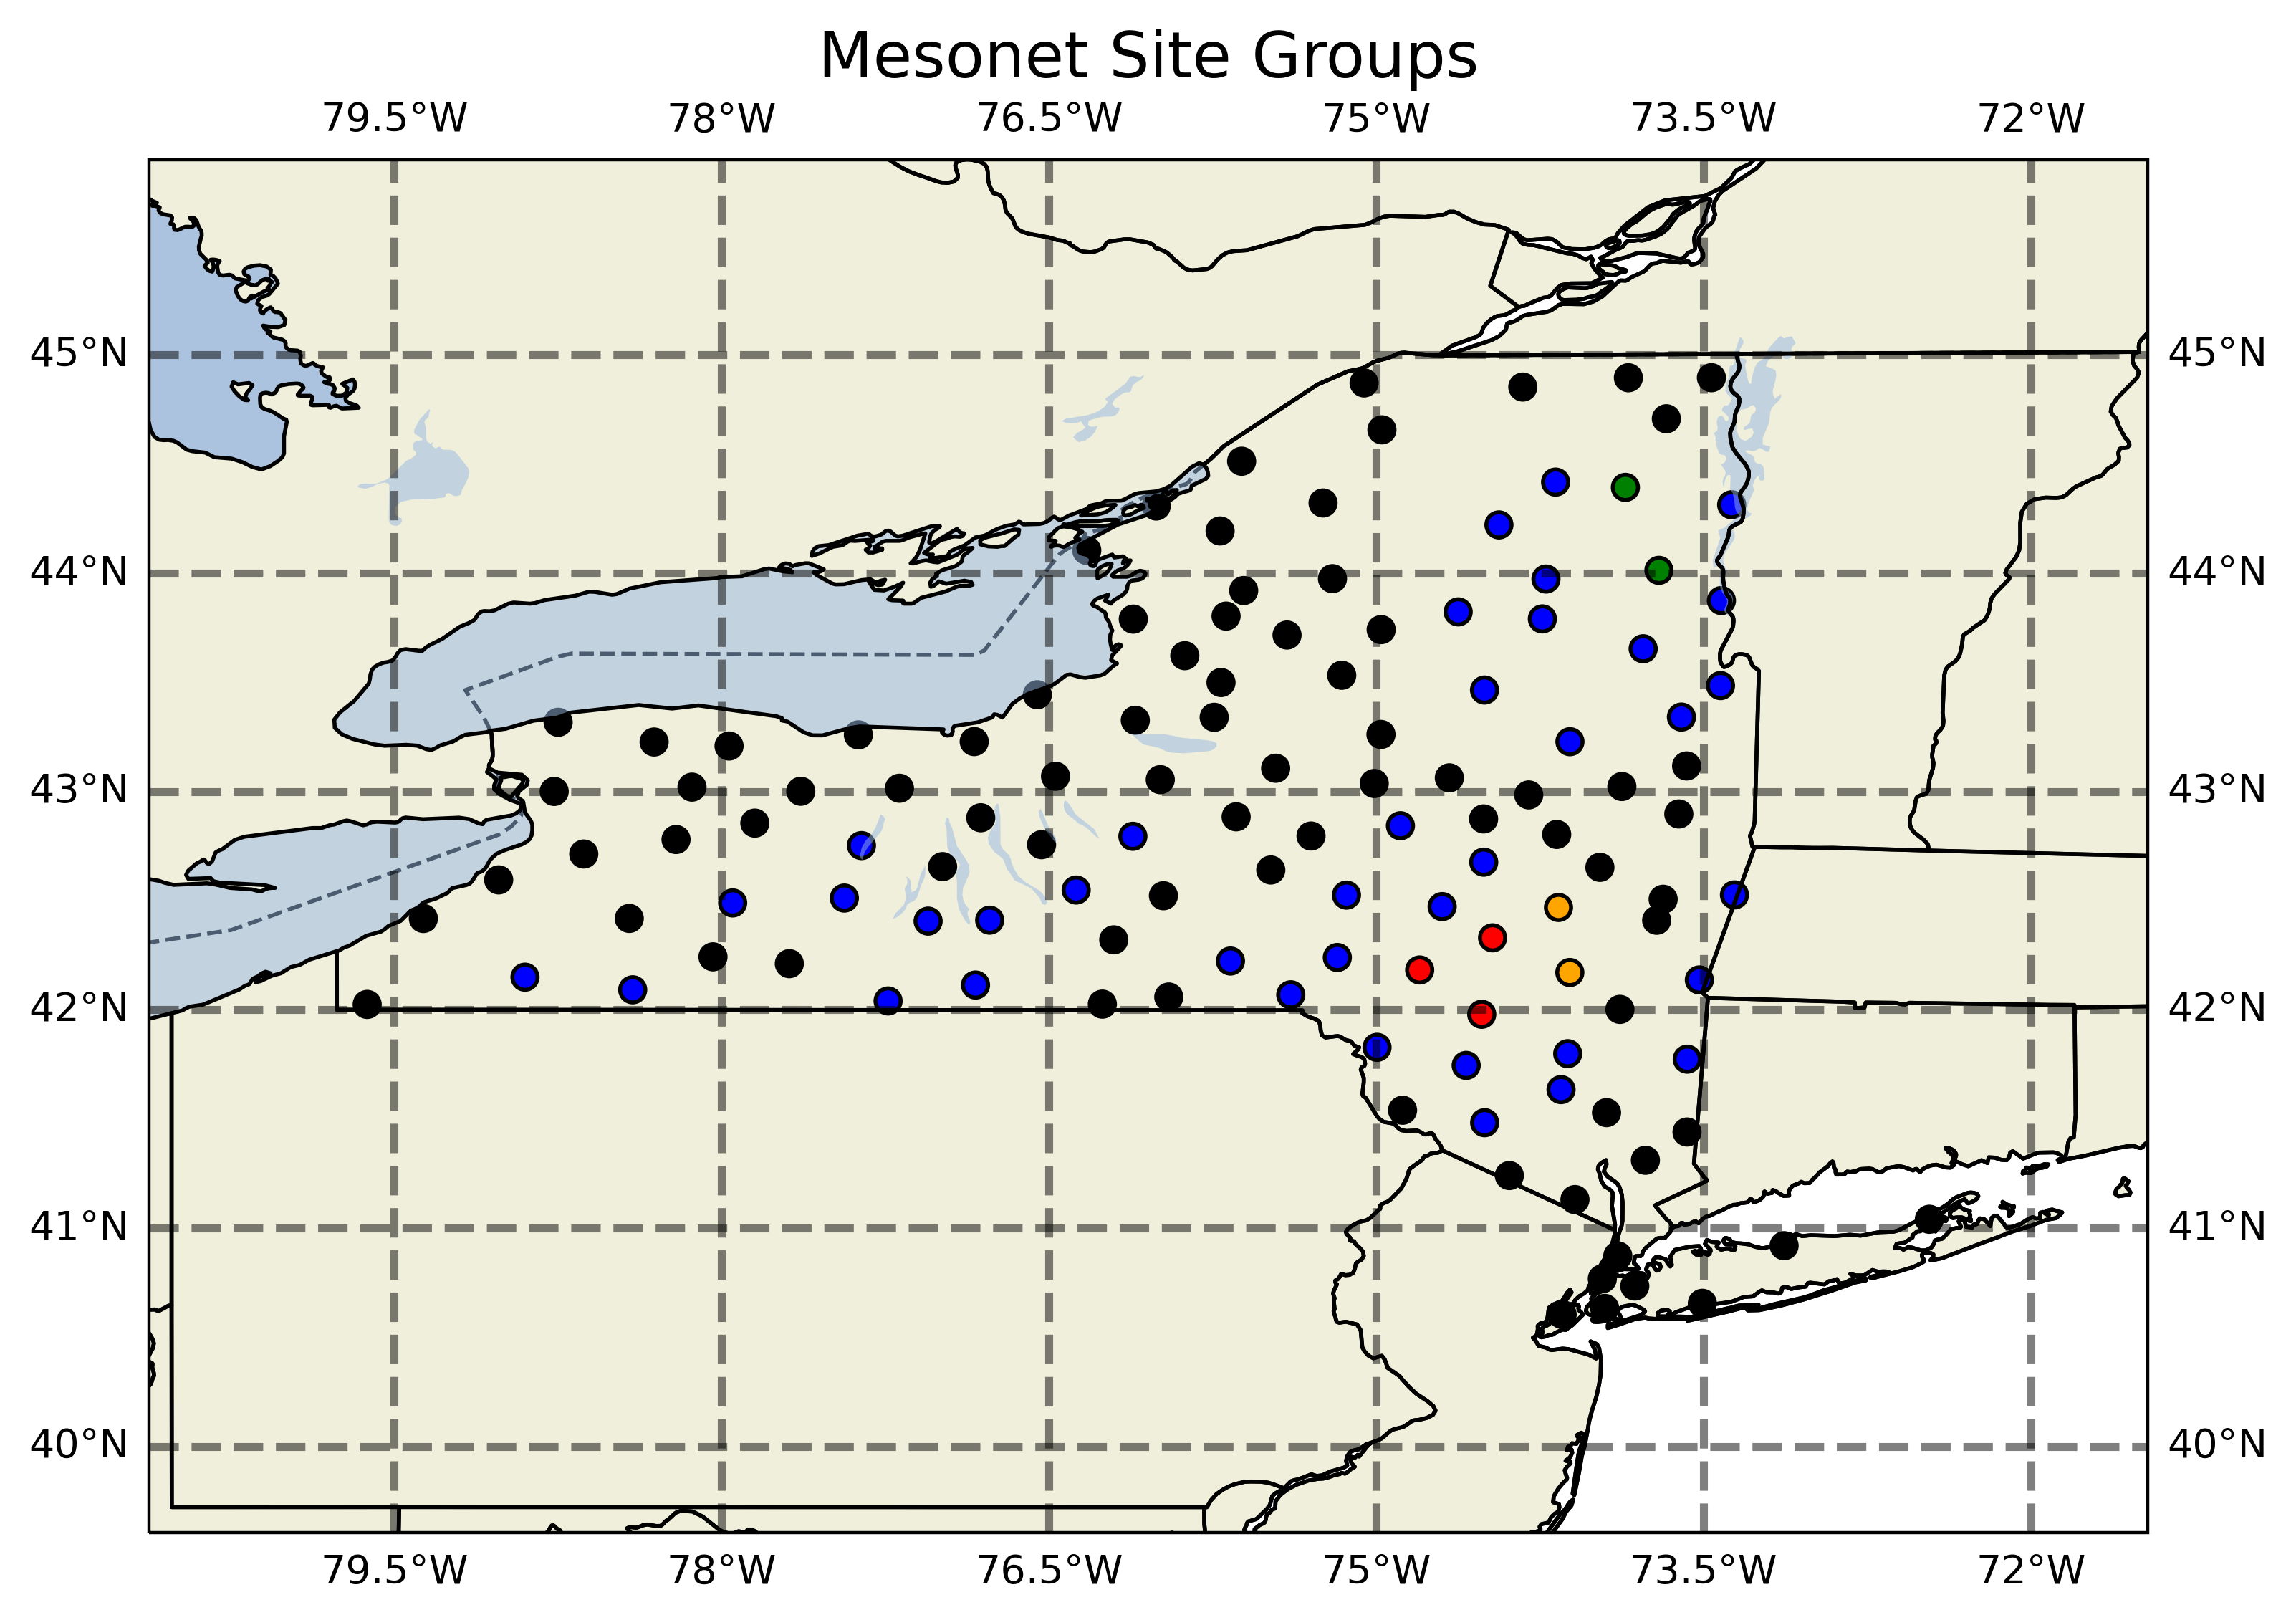

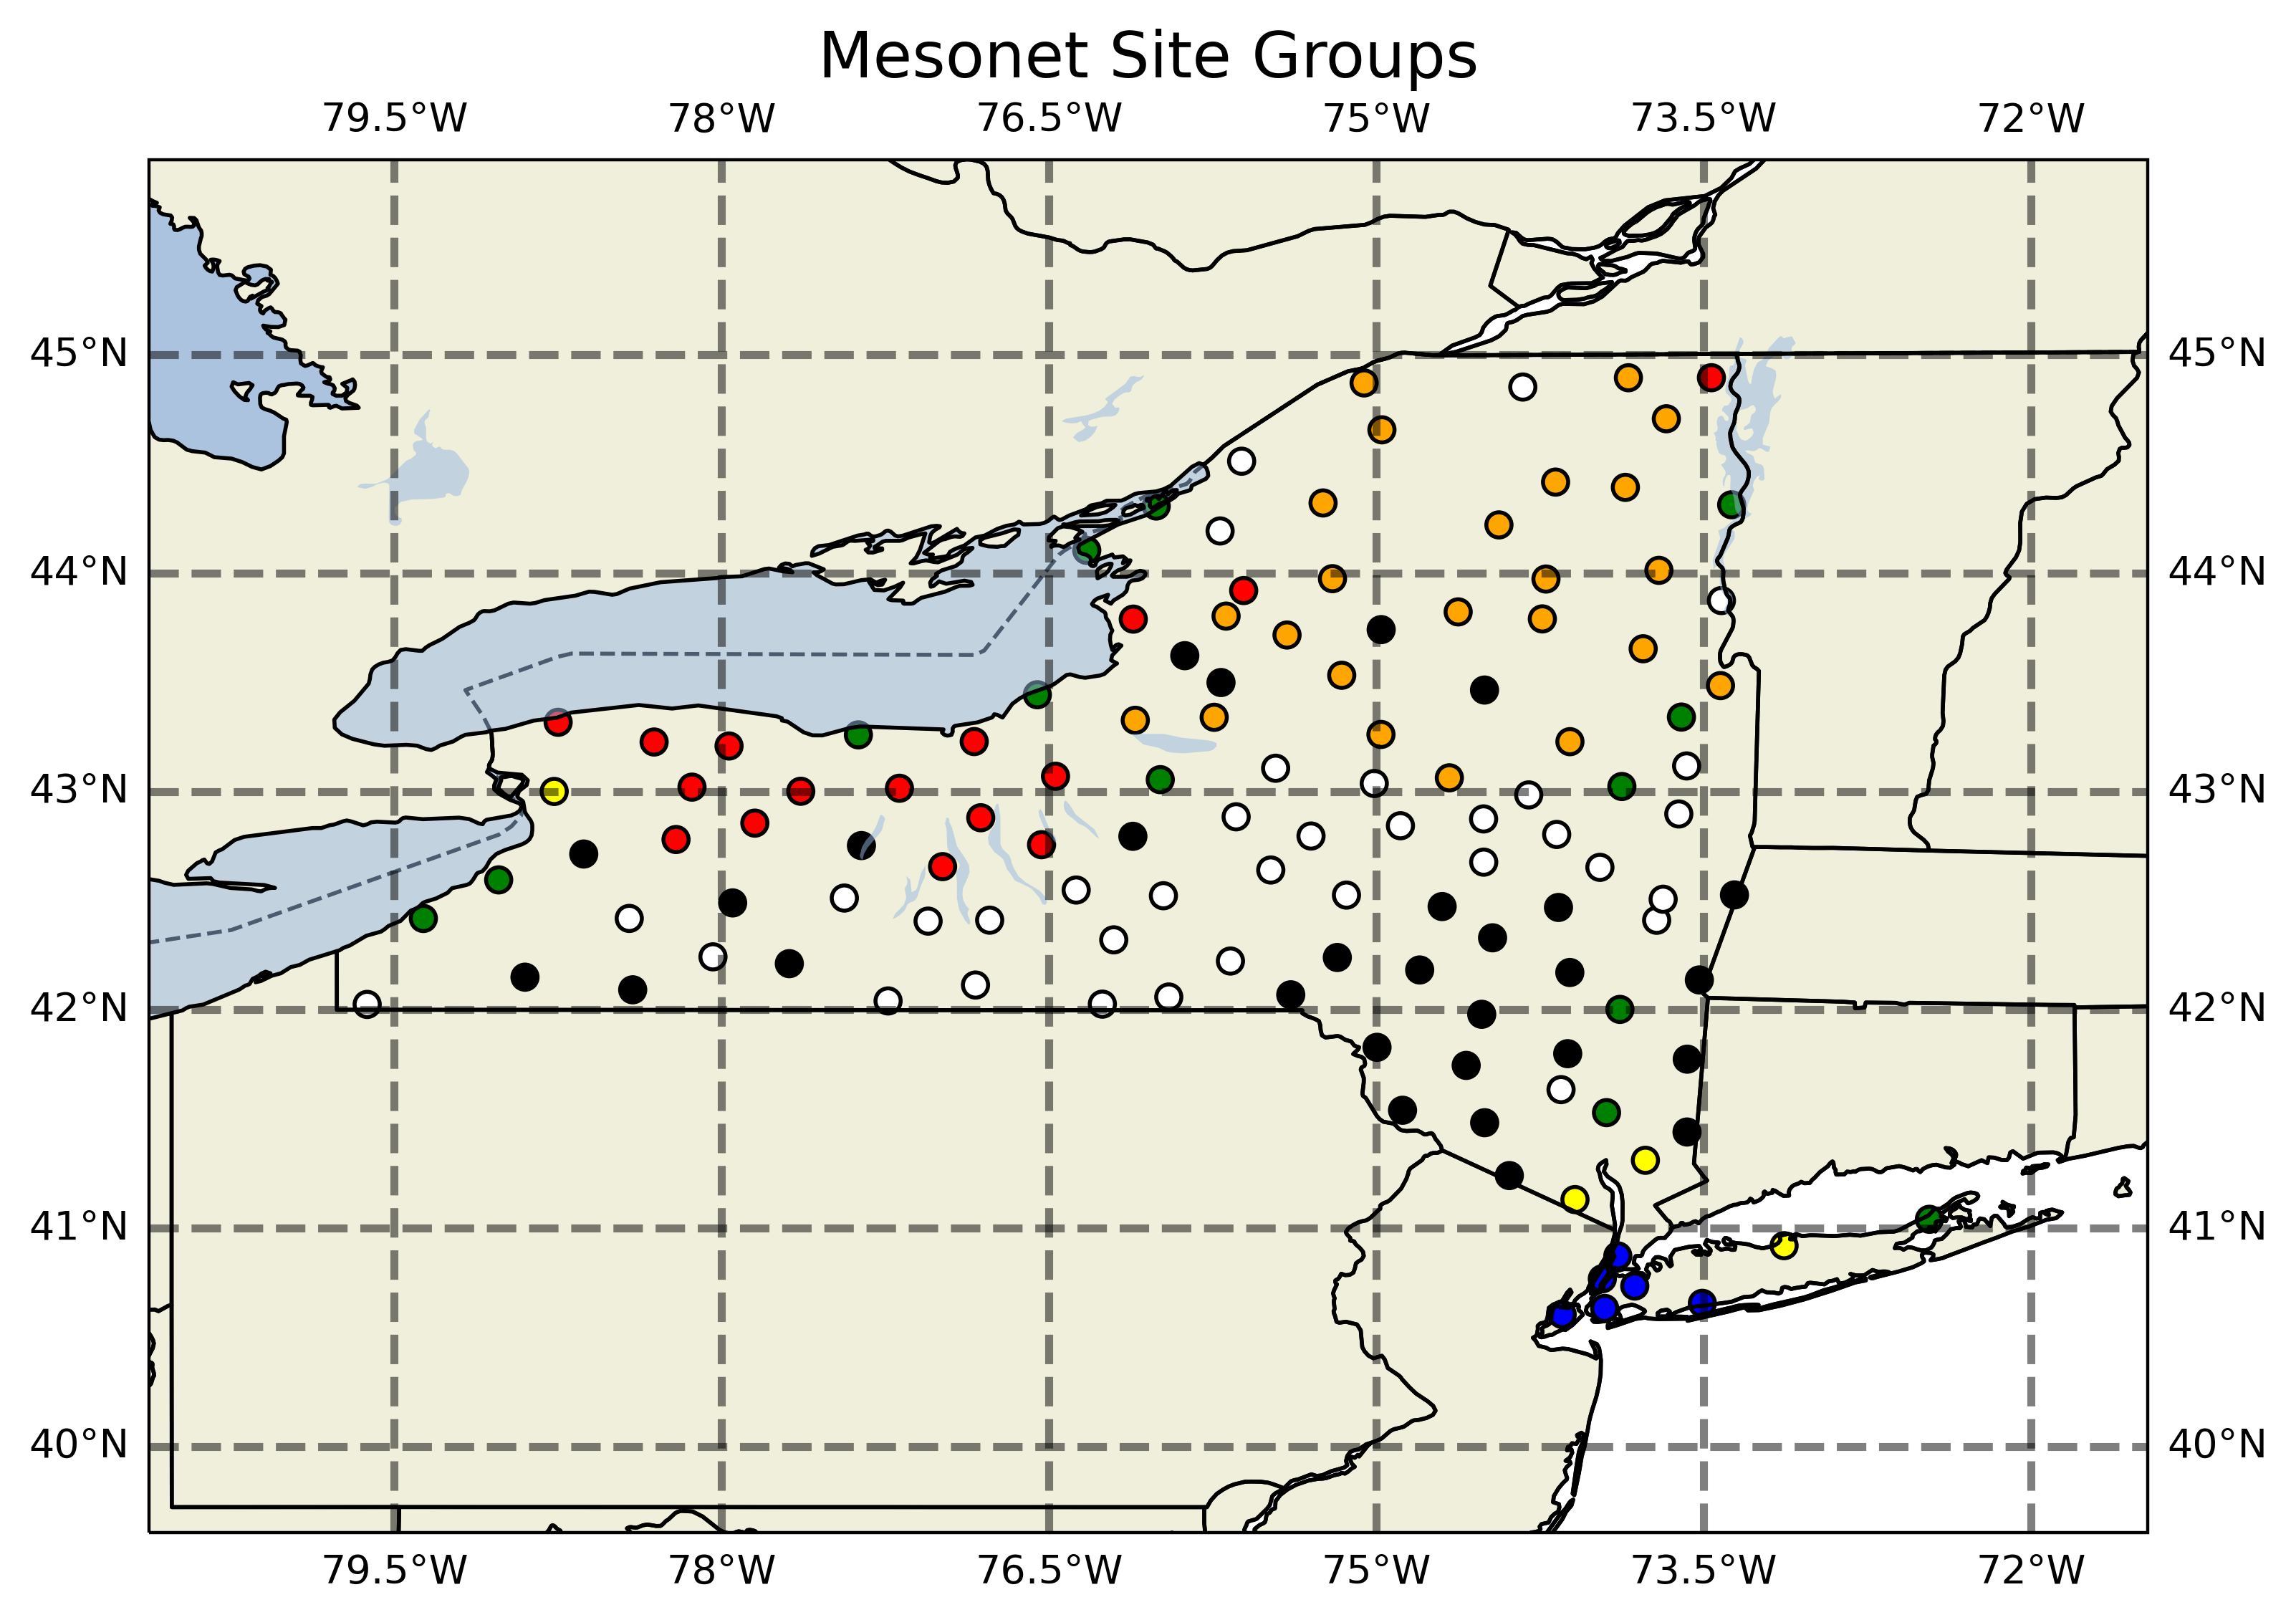

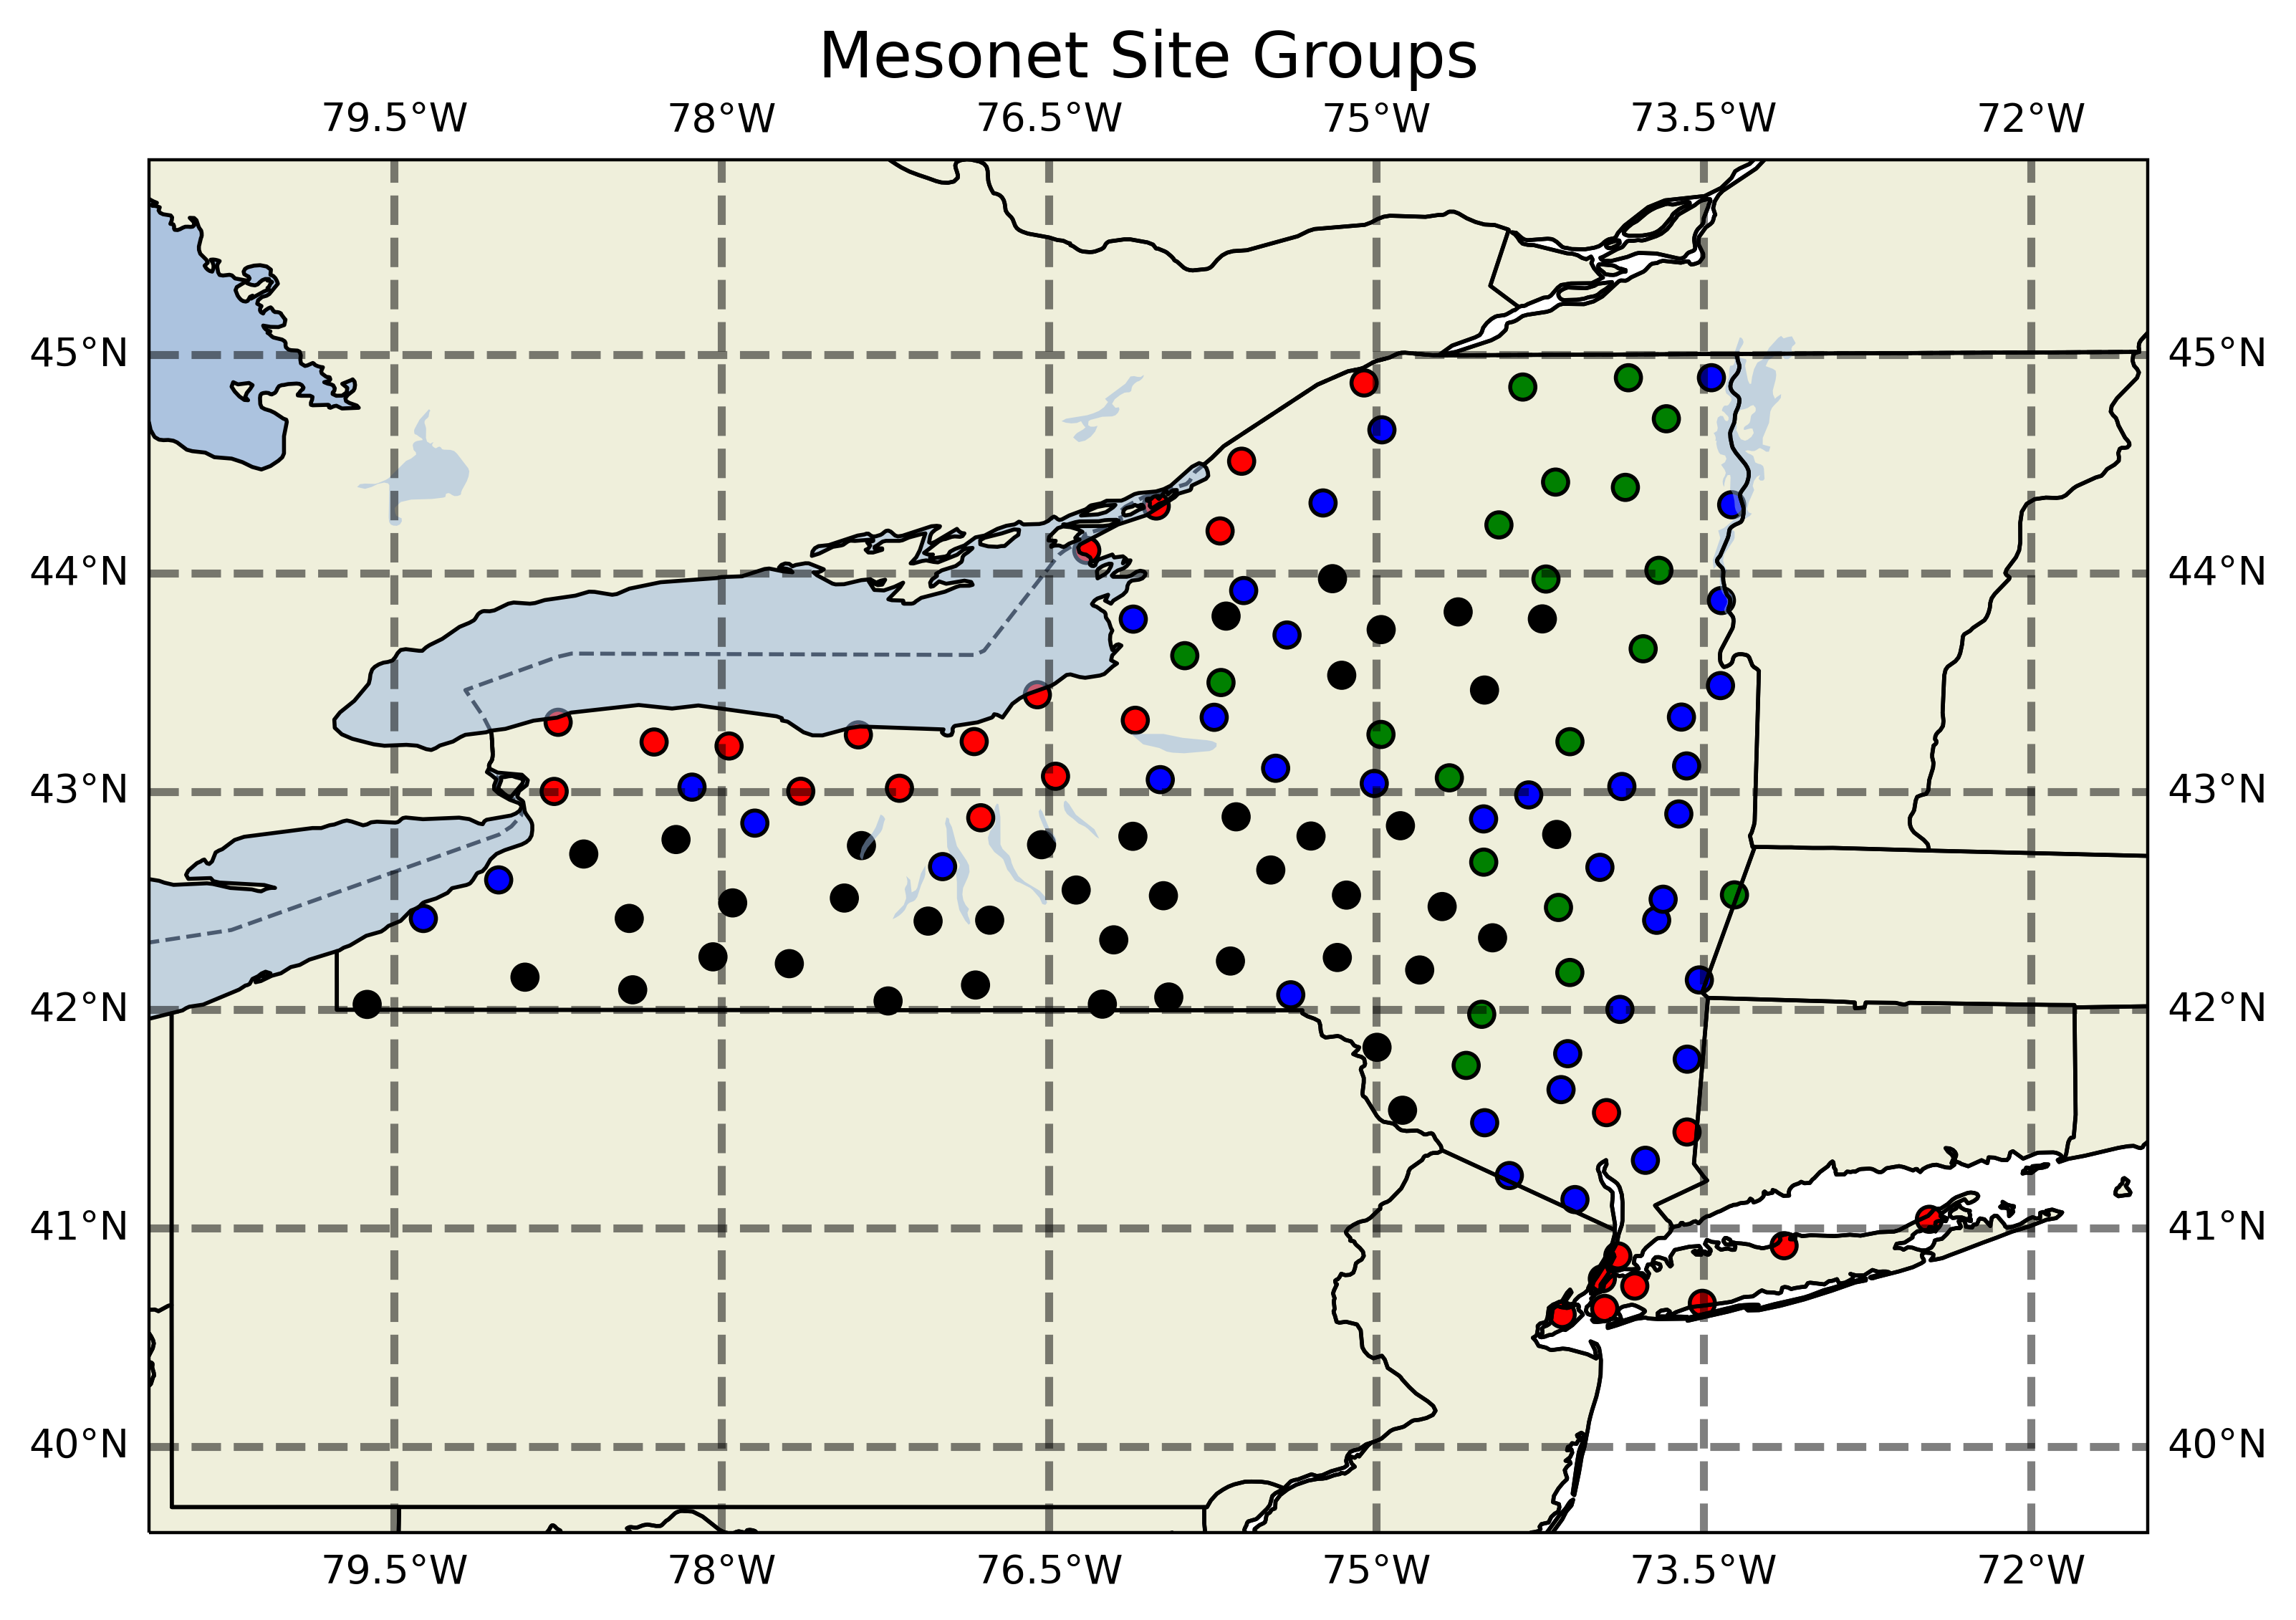

In [ ]:
plurality_plot(sortslopes)
plurality_plot(sortclasses)
plurality_plot(sortelevs)

# Let's cluster on all vars

In [ ]:
comb = pd.merge(df_lulc, elev_df, on="station")
comb.head()

site         11         21         22        23        24        31  \
0     1   1.962930   5.647257   1.299929  0.483068  0.109736  0.137242   
1     2   1.820203   4.007140   0.595656  0.093976  0.009168  0.090537   
2     3   0.697071   5.277453   4.213367  2.021878  0.932866  0.281350   
3     4  10.653124  11.111843  10.012464  9.876366  3.972609  0.532928   
4     5   0.649265   4.491848   1.082204  0.356723  0.039254  0.121773   

          41        42         43  ...        95  station  Unnamed: 0  \
0  29.370894  3.830164  25.780258  ...  0.554411     ADDI           0   
1  66.349595  2.819553  11.070490  ...  0.103430     ANDE           1   
2   7.929932  0.161303   1.428809  ...  1.017672     BATA           2   
3  42.712777  0.089967   0.535507  ...  0.546395     BEAC           3   
4  28.382281  6.408126  31.918283  ...  0.314318     BELD           4   

       elev         std      variance      skew    med_dist        lon  \
0  507.6140   78.927280   6227.304936 -0.137953  533.728027 -77.237259   
1  518.2820  114.446243  13093.302806  0.554366  428.563965 -74.801392   
2  276.1200   81.741875   6679.365616  1.134595  325.239990 -78.135658   
3   90.1598   77.445227   5995.644516  0.642901   43.319595 -73.945267   
4  470.3700   71.198890   5067.491291 -0.024945  520.739990 -75.668518   

         lat  
0  42.040359  
1  42.182270  
2  43.019939  
3  41.528751  
4  42.223221  

[5 rows x 25 columns]

In [ ]:
comb_df = pd.merge(comb, slope_df, on="station")

In [ ]:
comb_df.head()

site_x         11       21_x       22_x      23_x      24_x      31_x  \
0       1   1.962930   5.647257   1.299929  0.483068  0.109736  0.137242   
1       2   1.820203   4.007140   0.595656  0.093976  0.009168  0.090537   
2       3   0.697071   5.277453   4.213367  2.021878  0.932866  0.281350   
3       4  10.653124  11.111843  10.012464  9.876366  3.972609  0.532928   
4       5   0.649265   4.491848   1.082204  0.356723  0.039254  0.121773   

          41        42         43  ...        27        28   33   37   32  \
0  29.370894  3.830164  25.780258  ...  2.558480  3.070175  0.0  0.0  0.0   
1  66.349595  2.819553  11.070490  ...  6.695005  7.970244  0.0  0.0  0.0   
2   7.929932  0.161303   1.428809  ...  0.438276  0.255661  0.0  0.0  0.0   
3  42.712777  0.089967   0.535507  ...  3.123878  2.046679  0.0  0.0  0.0   
4  28.382281  6.408126  31.918283  ...  3.708937  3.355705  0.0  0.0  0.0   

    34   38  31_y   35   36  
0  0.0  0.0   0.0  0.0  0.0  
1  0.0  0.0   0.0  0.0  0.0  
2  0.0  0.0   0.0  0.0  0.0  
3  0.0  0.0   0.0  0.0  0.0  
4  0.0  0.0   0.0  0.0  0.0  

[5 rows x 43 columns]

In [ ]:
features_all = comb_df.drop(
    ["site_x", "station", "variance", "Unnamed: 0", "lon", "lat", "site_y"], axis=1
)
features_all.head()

11       21_x       22_x      23_x      24_x      31_x         41  \
0   1.962930   5.647257   1.299929  0.483068  0.109736  0.137242  29.370894   
1   1.820203   4.007140   0.595656  0.093976  0.009168  0.090537  66.349595   
2   0.697071   5.277453   4.213367  2.021878  0.932866  0.281350   7.929932   
3  10.653124  11.111843  10.012464  9.876366  3.972609  0.532928  42.712777   
4   0.649265   4.491848   1.082204  0.356723  0.039254  0.121773  28.382281   

         42         43        52  ...        27        28   33   37   32   34  \
0  3.830164  25.780258  0.441523  ...  2.558480  3.070175  0.0  0.0  0.0  0.0   
1  2.819553  11.070490  0.875577  ...  6.695005  7.970244  0.0  0.0  0.0  0.0   
2  0.161303   1.428809  0.209436  ...  0.438276  0.255661  0.0  0.0  0.0  0.0   
3  0.089967   0.535507  0.405427  ...  3.123878  2.046679  0.0  0.0  0.0  0.0   
4  6.408126  31.918283  0.320048  ...  3.708937  3.355705  0.0  0.0  0.0  0.0   

    38  31_y   35   36  
0  0.0   0.0  0.0  0.0  
1  0.0   0.0  0.0  0.0  
2  0.0   0.0  0.0  0.0  
3  0.0   0.0  0.0  0.0  
4  0.0   0.0  0.0  0.0  

[5 rows x 36 columns]

In [ ]:
features_all.keys()

Index(['11', '21_x', '22_x', '23_x', '24_x', '31_x', '41', '42', '43', '52',
       '71', '81', '82', '90', '95', 'elev', 'std', 'skew', 'med_dist', '19',
       '21_y', '22_y', '23_y', '24_y', '25', '26', '27', '28', '33', '37',
       '32', '34', '38', '31_y', '35', '36'],
      dtype='object')

In [ ]:
# features_all.to_csv("/home/aevans/landtype/notebooks/features.csv")

In [ ]:
features_all.head()

11       21_x       22_x      23_x      24_x      31_x         41  \
0   1.962930   5.647257   1.299929  0.483068  0.109736  0.137242  29.370894   
1   1.820203   4.007140   0.595656  0.093976  0.009168  0.090537  66.349595   
2   0.697071   5.277453   4.213367  2.021878  0.932866  0.281350   7.929932   
3  10.653124  11.111843  10.012464  9.876366  3.972609  0.532928  42.712777   
4   0.649265   4.491848   1.082204  0.356723  0.039254  0.121773  28.382281   

         42         43        52  ...        27        28   33   37   32   34  \
0  3.830164  25.780258  0.441523  ...  2.558480  3.070175  0.0  0.0  0.0  0.0   
1  2.819553  11.070490  0.875577  ...  6.695005  7.970244  0.0  0.0  0.0  0.0   
2  0.161303   1.428809  0.209436  ...  0.438276  0.255661  0.0  0.0  0.0  0.0   
3  0.089967   0.535507  0.405427  ...  3.123878  2.046679  0.0  0.0  0.0  0.0   
4  6.408126  31.918283  0.320048  ...  3.708937  3.355705  0.0  0.0  0.0  0.0   

    38  31_y   35   36  
0  0.0   0.0  0.0  0.0  
1  0.0   0.0  0.0  0.0  
2  0.0   0.0  0.0  0.0  
3  0.0   0.0  0.0  0.0  
4  0.0   0.0  0.0  0.0  

[5 rows x 36 columns]

In [ ]:
# noramalize data
scaler = preprocessing.MinMaxScaler()
features_norm_a = scaler.fit_transform(features_all)

In [ ]:
# kmeans clustering
inertia_elev = []
K = range(1, 40)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(features_norm_a)
    kmeanModel.fit(features_norm_a)
    inertia_elev.append(kmeanModel.inertia_)

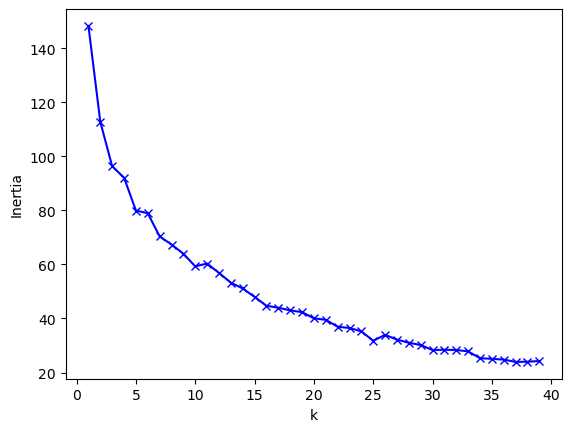

In [ ]:
# Plot the elbow
plt.plot(K, inertia_elev, "bx-")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.show()

In [ ]:
# let's say our elbow is 12
kmeans_all = KMeans(n_clusters=10).fit(features_norm_a)

In [ ]:
features_all.head()

11       21_x       22_x      23_x      24_x      31_x         41  \
0   1.962930   5.647257   1.299929  0.483068  0.109736  0.137242  29.370894   
1   1.820203   4.007140   0.595656  0.093976  0.009168  0.090537  66.349595   
2   0.697071   5.277453   4.213367  2.021878  0.932866  0.281350   7.929932   
3  10.653124  11.111843  10.012464  9.876366  3.972609  0.532928  42.712777   
4   0.649265   4.491848   1.082204  0.356723  0.039254  0.121773  28.382281   

         42         43        52  ...        27        28   33   37   32   34  \
0  3.830164  25.780258  0.441523  ...  2.558480  3.070175  0.0  0.0  0.0  0.0   
1  2.819553  11.070490  0.875577  ...  6.695005  7.970244  0.0  0.0  0.0  0.0   
2  0.161303   1.428809  0.209436  ...  0.438276  0.255661  0.0  0.0  0.0  0.0   
3  0.089967   0.535507  0.405427  ...  3.123878  2.046679  0.0  0.0  0.0  0.0   
4  6.408126  31.918283  0.320048  ...  3.708937  3.355705  0.0  0.0  0.0  0.0   

    38  31_y   35   36  
0  0.0   0.0  0.0  0.0  
1  0.0   0.0  0.0  0.0  
2  0.0   0.0  0.0  0.0  
3  0.0   0.0  0.0  0.0  
4  0.0   0.0  0.0  0.0  

[5 rows x 36 columns]

In [ ]:
labels_a = pd.DataFrame(
    kmeans_all.labels_
)  # This is where the label output of the KMeans we just ran lives. Make it a dataframe so we can concatenate back to the original data
labeledAll = pd.concat((features_all, labels_a), axis=1)
labeledAll = labeledAll.rename({0: "labels"}, axis=1)

In [ ]:
labeledAll.head()

11       21_x       22_x      23_x      24_x      31_x         41  \
0   1.962930   5.647257   1.299929  0.483068  0.109736  0.137242  29.370894   
1   1.820203   4.007140   0.595656  0.093976  0.009168  0.090537  66.349595   
2   0.697071   5.277453   4.213367  2.021878  0.932866  0.281350   7.929932   
3  10.653124  11.111843  10.012464  9.876366  3.972609  0.532928  42.712777   
4   0.649265   4.491848   1.082204  0.356723  0.039254  0.121773  28.382281   

         42         43        52  ...        28   33   37   32   34   38  \
0  3.830164  25.780258  0.441523  ...  3.070175  0.0  0.0  0.0  0.0  0.0   
1  2.819553  11.070490  0.875577  ...  7.970244  0.0  0.0  0.0  0.0  0.0   
2  0.161303   1.428809  0.209436  ...  0.255661  0.0  0.0  0.0  0.0  0.0   
3  0.089967   0.535507  0.405427  ...  2.046679  0.0  0.0  0.0  0.0  0.0   
4  6.408126  31.918283  0.320048  ...  3.355705  0.0  0.0  0.0  0.0  0.0   

   31_y   35   36  labels  
0   0.0  0.0  0.0       0  
1   0.0  0.0  0.0       8  
2   0.0  0.0  0.0       9  
3   0.0  0.0  0.0       1  
4   0.0  0.0  0.0       0  

[5 rows x 37 columns]

In [ ]:
# sns.pairplot(labeledAll,hue='labels')

In [ ]:
labeledAll[
    "Constant"
] = "Data"  # This is just to add something constant for the strip/swarm plots' X axis. Can be anything you want it to be.

In [ ]:
# f, axes = plt.subplots(4, 5, figsize=(20, 25), sharex=False) #create a 4x5 grid of empty figures where we will plot our feature plots. We will have a couple empty ones.
# f.subplots_adjust(hspace=0.2, wspace=0.7) #Scooch em apart, give em some room
# #In this for loop, I step through every column that I want to plot. This is a 4x5 grid, so I split this up by rows of 5 in the else if statements
# for i in range(0,len(list(labeledAll))-2): #minus two because I don't want to plot labels or constant
#     col = labeledAll.columns[i]
#     if i < 5:
#         ax = sns.stripplot(x=labeledAll['Constant'],y=labeledAll[col].values,hue=labeledAll['labels'],jitter=True,ax=axes[0,(i)])
#         ax.set_title(col)
#     elif i >= 5 and i<10:
#         ax = sns.stripplot(x=labeledAll['Constant'],y=labeledAll[col].values,hue=labeledAll['labels'],jitter=True,ax=axes[1,(i-5)]) #so if i=6 it is row 1 column 1
#         ax.set_title(col)
#     elif i >= 10 and i<15:
#         ax = sns.stripplot(x=labeledAll['Constant'],y=labeledAll[col].values,hue=labeledAll['labels'],jitter=True,ax=axes[2,(i-10)])
#         ax.set_title(col)
#     elif i >= 15 and i<20:
#         ax = sns.stripplot(x=labeledAll['Constant'],y=labeledAll[col].values,hue=labeledAll['labels'],jitter=True,ax=axes[3,(i-15)])
#         ax.set_title(col)
#     elif i >= 20:
#         ax = sns.stripplot(x=labeledAll['Constant'],y=labeledAll[col].values,hue=labeledAll['labels'],jitter=True,ax=axes[4,(i-20)])
#         ax.set_title(col)

In [ ]:
# f, axes = plt.subplots(4, 5, figsize=(20, 25), sharex=False)
# f.subplots_adjust(hspace=0.2, wspace=0.7)
# for i in range(0,len(list(labeledAll))-2):
#     col = labeledAll.columns[i]
#     if i < 5:
#         ax = sns.swarmplot(x=labeledAll['Constant'],y=labeledAll[col].values,hue=labeledAll['labels'],ax=axes[0,(i)])
#         ax.set_title(col)
#     elif i >= 5 and i<10:
#         ax = sns.swarmplot(x=labeledAll['Constant'],y=labeledAll[col].values,hue=labeledAll['labels'],ax=axes[1,(i-5)])
#         ax.set_title(col)
#     elif i >= 10 and i<15:
#         ax = sns.swarmplot(x=labeledAll['Constant'],y=labeledAll[col].values,hue=labeledAll['labels'],ax=axes[2,(i-10)])
#         ax.set_title(col)
#     elif i >= 15 and i <20:
#         ax = sns.swarmplot(x=labeledAll['Constant'],y=labeledAll[col].values,hue=labeledAll['labels'],ax=axes[3,(i-15)])
#         ax.set_title(col)
#     elif i >= 20:
#         ax = sns.stripplot(x=labeledAll['Constant'],y=labeledAll[col].values,hue=labeledAll['labels'],jitter=True,ax=axes[3,(i-20)])
#         ax.set_title(col)

In [ ]:
alls = df_lulc["station"]
alls = pd.concat((alls, labels_a), axis=1)
alls = alls.rename({"station": "station", 0: "Cluster"}, axis=1)
sortAll = alls.sort_values(["station"])
pd.set_option("display.max_rows", 1000)
sortAll["lon"] = ny_df_lons
sortAll["lat"] = ny_df_lats

In [ ]:
colors = [
    "black",
    "blue",
    "white",
    "coral",
    "pink",
    "red",
    "magenta",
    "gray",
    "lime",
    "forestgreen",
    "green",
    "olive",
    "brown",
    "slategray",
    "darkorchid",
    "plum",
    "indigo",
    "purple",
    "yellow",
    "gold",
    "orange",
    "cyan",
]
legend = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]

colordict = {}

for x, _ in enumerate(colors):
    colordict.update({legend[x]: colors[x]})

sortAll["color"] = sortAll["Cluster"].map(colordict)

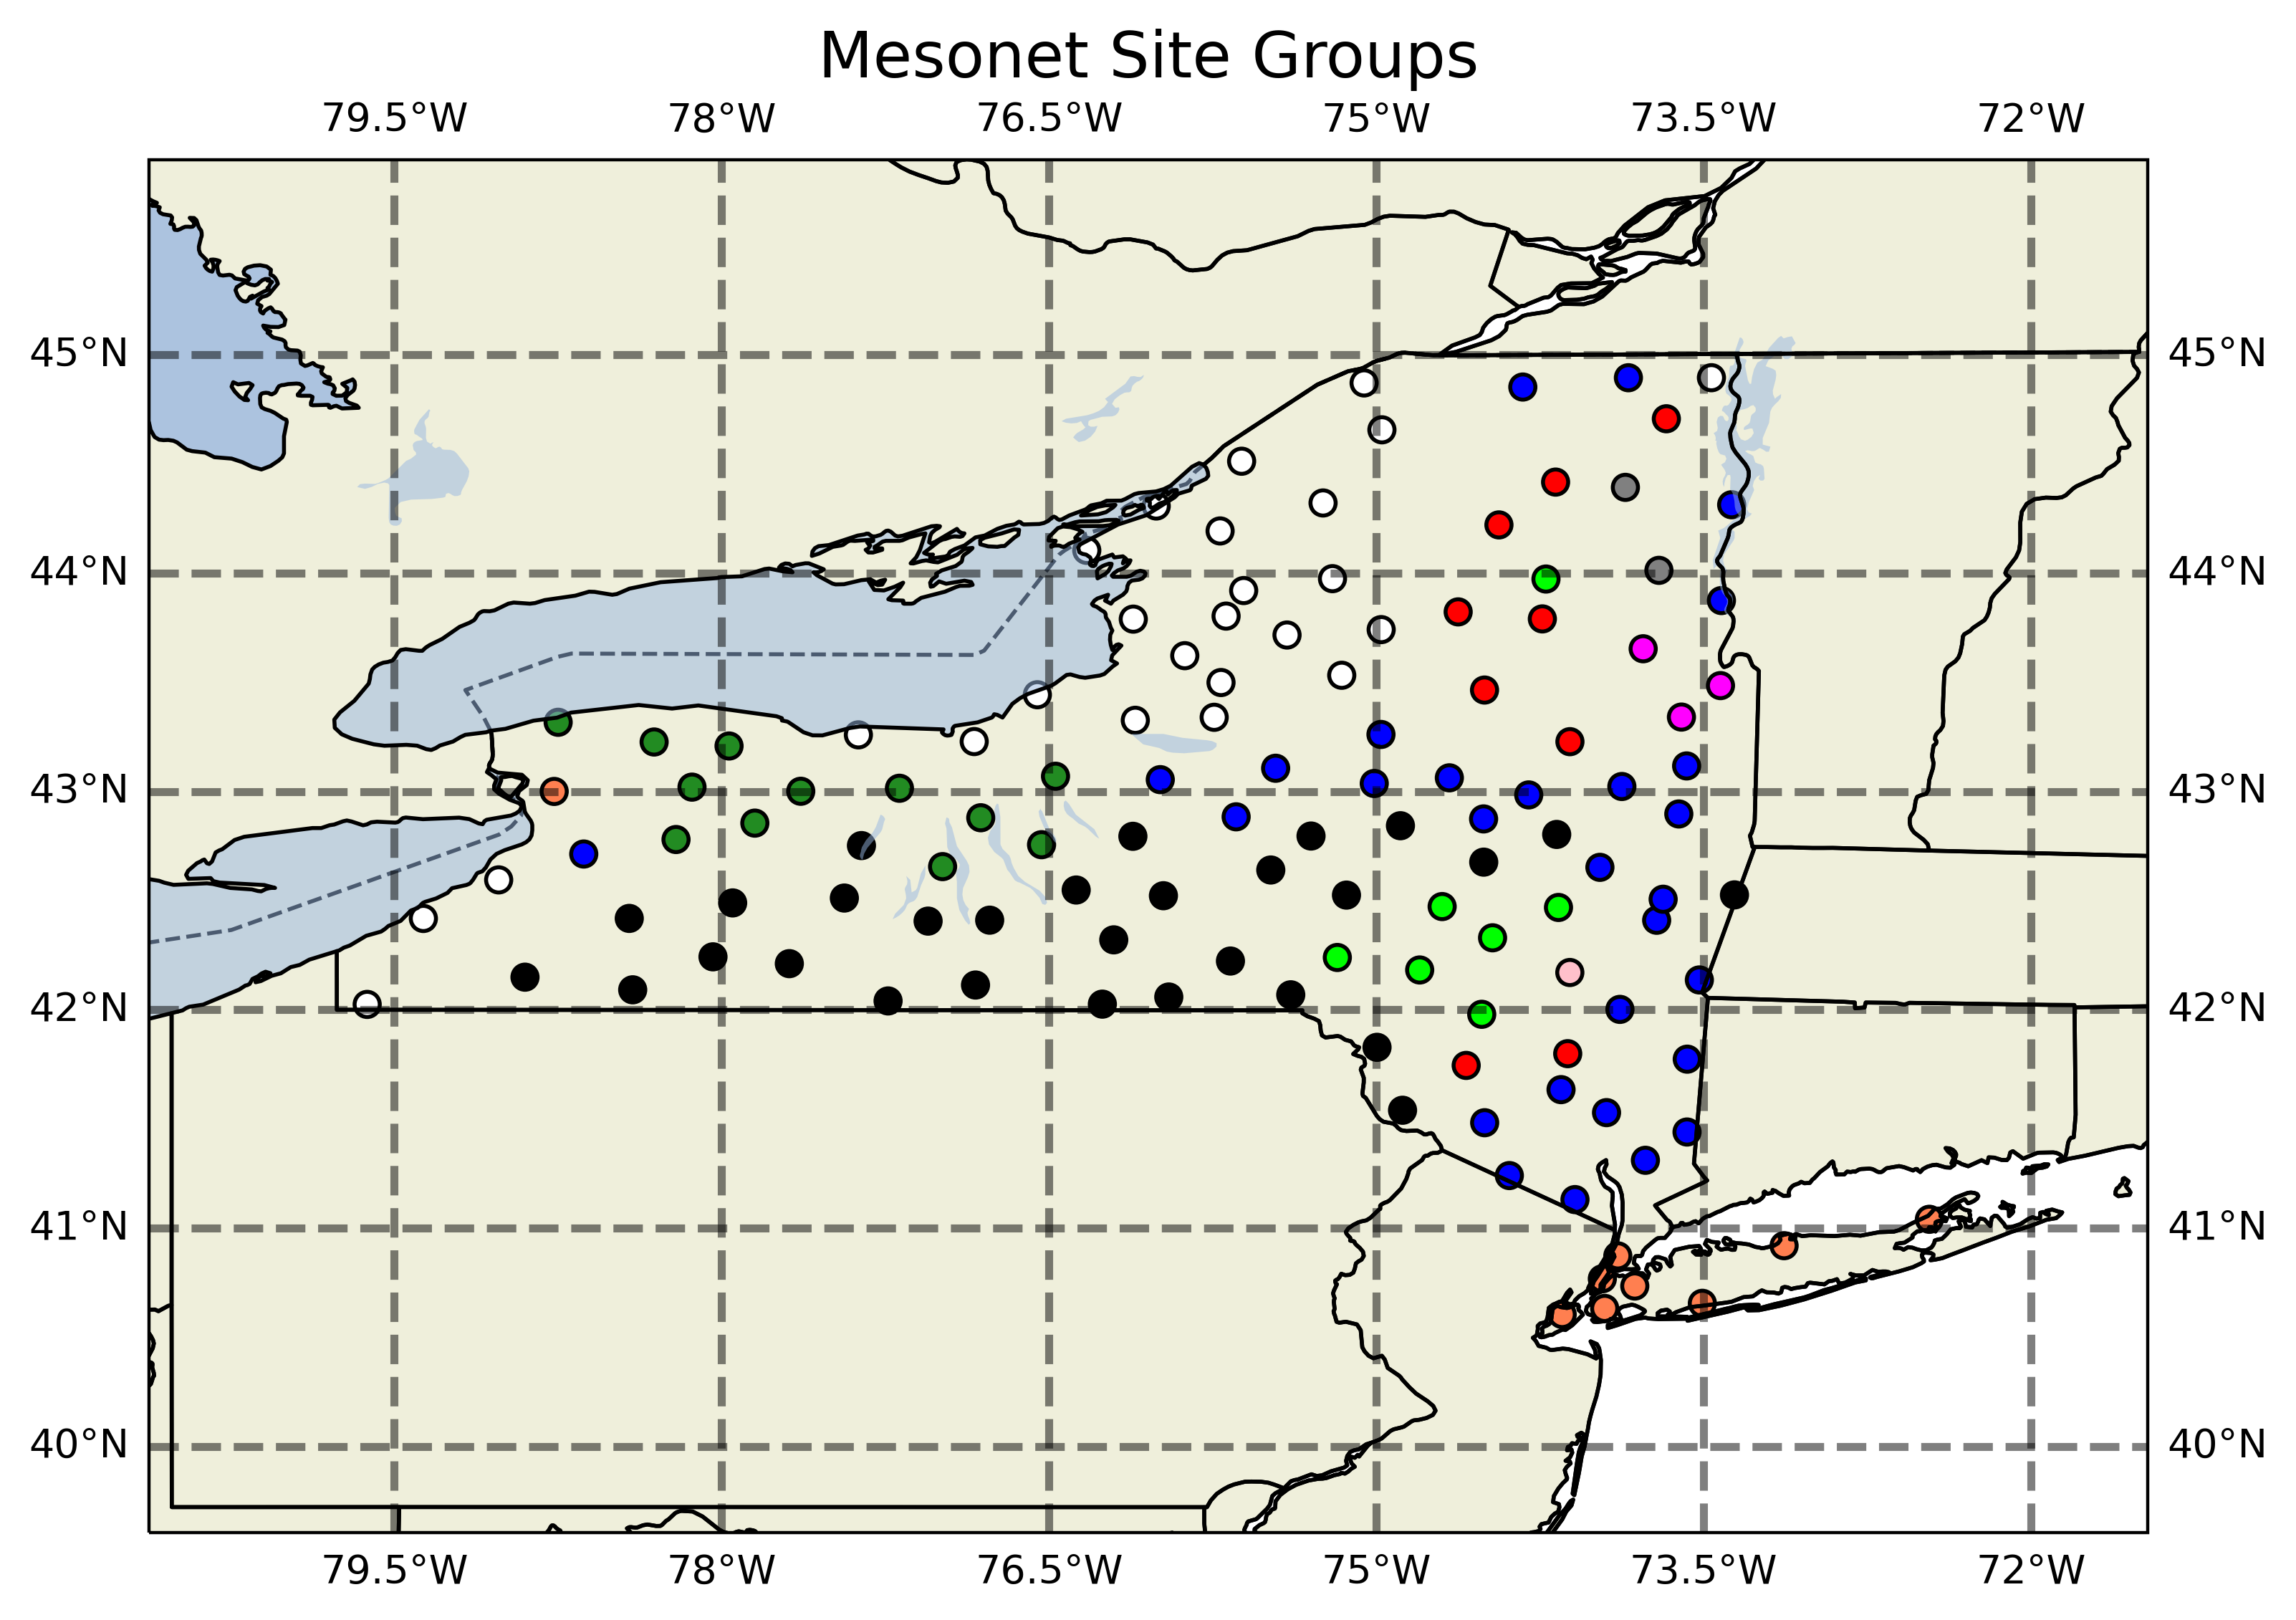

In [ ]:
plurality_plot(sortAll)

In [ ]:
sortAll.head()

station  Cluster        lon        lat        color
0    ADDI        0 -77.237259  42.040359        black
1    ANDE        8 -74.801392  42.182270         lime
2    BATA        9 -78.135658  43.019939  forestgreen
3    BEAC        1 -73.945267  41.528751         blue
4    BELD        0 -75.668518  42.223221        black

In [ ]:
sortAll.to_csv("/home/aevans/nwp_bias/src/landtype/data/ny_geo_clusters.csv")

In [ ]:
for i in np.arange(0, 12):
    slopes_cat = sortAll.loc[sortAll["Cluster"] == i]
    slopes_cat = pd.merge(slopes_cat, comb_df, on="station")
    slopes_cat = pd.merge(slopes_cat, df_land, on="station")
    plurality_plot_x(slopes_cat)
# slopes_cat.to_csv(f'/home/aevans/landtype/data/clean_cats/ny/df_{i}.csv')

NameError: name 'df_land' is not defined

In [ ]:
df_a = pd.read_csv(f"/home/aevans/landtype/data/clean_cats/ny/df_0.csv")
df_a.drop(
    columns=[
        "Unnamed: 0",
        "site_x",
        "11",
        "21_x",
        "22_x",
        "23_x",
        "24_x",
        "31_x",
        "41",
        "42",
        "43",
        "52",
        "71",
        "81",
        "82",
        "90",
        "95",
        "Unnamed: 0_x",
        "site_y",
        "19",
        "21_y",
        "22_y",
        "23_y",
        "24_y",
        "25",
        "26",
        "27",
        "28",
        "33",
        "37",
        "32",
        "34",
        "38",
        "31_y",
        "35",
        "36",
        "Unnamed: 0_y",
        "sum_total",
    ]
)

In [ ]:
plurality_plot_x(df_a)

In [ ]:
# for n,_ in enumerate(df_a['station']):
#     if df_a['lon_x'].iloc[n] < -76:
#         df_a['Cluster'].iloc[n] = 6
#     if df_a['lat_x'].iloc[n] < 43:
#         if df_a['lon_x'].iloc[n] > -75:
#             df_a['Cluster'].iloc[n] = 7
#     if df_a['lat_x'].iloc[n] > 43:
#         df_a['Cluster'].iloc[n] = 8

In [ ]:
df_b = pd.read_csv(f"/home/aevans/landtype/data/clean_cats/ny/df_1.csv")
df_b.drop(
    columns=[
        "Unnamed: 0",
        "site_x",
        "11",
        "21_x",
        "22_x",
        "23_x",
        "24_x",
        "31_x",
        "41",
        "42",
        "43",
        "52",
        "71",
        "81",
        "82",
        "90",
        "95",
        "Unnamed: 0_x",
        "site_y",
        "19",
        "21_y",
        "22_y",
        "23_y",
        "24_y",
        "25",
        "26",
        "27",
        "28",
        "33",
        "37",
        "32",
        "34",
        "38",
        "31_y",
        "35",
        "36",
        "Unnamed: 0_y",
        "sum_total",
    ]
)

In [ ]:
plurality_plot_x(df_b)

In [ ]:
# for n,_ in enumerate(df_b['station']):
#     if df_b['lat_x'].iloc[n] < 43.3:
#         if df_b['lon_x'] > -75:
#             df_b['Cluster'].iloc[n] = 9

In [ ]:
df_c = pd.read_csv(f"/home/aevans/landtype/data/clean_cats/ny/df_2.csv")
df_c.drop(
    columns=[
        "Unnamed: 0",
        "site_x",
        "11",
        "21_x",
        "22_x",
        "23_x",
        "24_x",
        "31_x",
        "41",
        "42",
        "43",
        "52",
        "71",
        "81",
        "82",
        "90",
        "95",
        "Unnamed: 0_x",
        "site_y",
        "19",
        "21_y",
        "22_y",
        "23_y",
        "24_y",
        "25",
        "26",
        "27",
        "28",
        "33",
        "37",
        "32",
        "34",
        "38",
        "31_y",
        "35",
        "36",
        "Unnamed: 0_y",
        "sum_total",
    ]
)

In [ ]:
plurality_plot_x(df_c)

In [ ]:
# for n,_ in enumerate(df_c['station']):
#     if df_c['lat'].iloc[n] < 43:
#         df_c['Cluster'].iloc[n] = 9

In [ ]:
df_d = pd.read_csv(f"/home/aevans/landtype/data/clean_cats/ny/df_3.csv")
df_d.drop(
    columns=[
        "Unnamed: 0",
        "site_x",
        "11",
        "21_x",
        "22_x",
        "23_x",
        "24_x",
        "31_x",
        "41",
        "42",
        "43",
        "52",
        "71",
        "81",
        "82",
        "90",
        "95",
        "Unnamed: 0_x",
        "site_y",
        "19",
        "21_y",
        "22_y",
        "23_y",
        "24_y",
        "25",
        "26",
        "27",
        "28",
        "33",
        "37",
        "32",
        "34",
        "38",
        "31_y",
        "35",
        "36",
        "Unnamed: 0_y",
        "sum_total",
    ]
)

In [ ]:
plurality_plot_x(df_d)

In [ ]:
# for n,_ in enumerate(df_d['station']):
#     if df_d['lat'].iloc[n] < 42.6:
#         if df_d['lon'].iloc[n] > -75:
#             df_d['Cluster'].iloc[n] = 10
#         if df_d['lon'].iloc[n] < -78:
#             df_d['Cluster'].iloc[n] = 11
#     if df_d['lat'].iloc[n] >= 42.6:
#         if df_d['lon'].iloc[n] < -74.1:
#             if df_d['lat'].iloc[n] < 44:
#                 df_d['Cluster'].iloc[n] = 12

In [ ]:
df_e = pd.read_csv(f"/home/aevans/landtype/data/clean_cats/ny/df_4.csv")
df_e.drop(
    columns=[
        "Unnamed: 0",
        "site_x",
        "11",
        "21_x",
        "22_x",
        "23_x",
        "24_x",
        "31_x",
        "41",
        "42",
        "43",
        "52",
        "71",
        "81",
        "82",
        "90",
        "95",
        "Unnamed: 0_x",
        "site_y",
        "19",
        "21_y",
        "22_y",
        "23_y",
        "24_y",
        "25",
        "26",
        "27",
        "28",
        "33",
        "37",
        "32",
        "34",
        "38",
        "31_y",
        "35",
        "36",
        "Unnamed: 0_y",
        "sum_total",
    ]
)

In [ ]:
plurality_plot_x(df_e)

In [ ]:
# for n,_ in enumerate(df_e['station']):
#     if df_e['lon'].iloc[n] < -76:
#         df_e['Cluster'].iloc[n] = 13

In [ ]:
df_f = pd.read_csv(f"/home/aevans/landtype/data/clean_cats/ny/df_5.csv")
df_f.drop(
    columns=[
        "Unnamed: 0",
        "site_x",
        "11",
        "21_x",
        "22_x",
        "23_x",
        "24_x",
        "31_x",
        "41",
        "42",
        "43",
        "52",
        "71",
        "81",
        "82",
        "90",
        "95",
        "Unnamed: 0_x",
        "site_y",
        "19",
        "21_y",
        "22_y",
        "23_y",
        "24_y",
        "25",
        "26",
        "27",
        "28",
        "33",
        "37",
        "32",
        "34",
        "38",
        "31_y",
        "35",
        "36",
        "Unnamed: 0_y",
        "sum_total",
    ]
)

In [ ]:
plurality_plot_x(df_f)

In [ ]:
df_g = pd.read_csv(f"/home/aevans/landtype/data/clean_cats/ny/df_6.csv")
df_g.drop(
    columns=[
        "Unnamed: 0",
        "site_x",
        "11",
        "21_x",
        "22_x",
        "23_x",
        "24_x",
        "31_x",
        "41",
        "42",
        "43",
        "52",
        "71",
        "81",
        "82",
        "90",
        "95",
        "Unnamed: 0_x",
        "site_y",
        "19",
        "21_y",
        "22_y",
        "23_y",
        "24_y",
        "25",
        "26",
        "27",
        "28",
        "33",
        "37",
        "32",
        "34",
        "38",
        "31_y",
        "35",
        "36",
        "Unnamed: 0_y",
        "sum_total",
    ]
)

In [ ]:
plurality_plot_x(df_g)

In [ ]:
df_h = pd.read_csv(f"/home/aevans/landtype/data/clean_cats/ny/df_7.csv")
df_h.drop(
    columns=[
        "Unnamed: 0",
        "site_x",
        "11",
        "21_x",
        "22_x",
        "23_x",
        "24_x",
        "31_x",
        "41",
        "42",
        "43",
        "52",
        "71",
        "81",
        "82",
        "90",
        "95",
        "Unnamed: 0_x",
        "site_y",
        "19",
        "21_y",
        "22_y",
        "23_y",
        "24_y",
        "25",
        "26",
        "27",
        "28",
        "33",
        "37",
        "32",
        "34",
        "38",
        "31_y",
        "35",
        "36",
        "Unnamed: 0_y",
        "sum_total",
    ]
)

In [ ]:
plurality_plot_x(df_h)

In [ ]:
# df_i = pd.read_csv(f'/home/aevans/landtype/data/clean_cats/ny/df_8.csv')
# df_i.drop(columns = ['Unnamed: 0', 'site_x',
#        '11', '21_x', '22_x', '23_x', '24_x', '31_x', '41', '42', '43', '52',
#        '71', '81', '82', '90', '95', 'Unnamed: 0_x','site_y', '19', '21_y', '22_y',
#        '23_y', '24_y', '25', '26', '27', '28', '33', '37', '32', '34', '38',
#        '31_y', '35', '36', 'Unnamed: 0_y', 'sum_total' ])

In [ ]:
# plurality_plot_x(df_i)

In [ ]:
# df_j = pd.read_csv(f'/home/aevans/landtype/data/clean_cats/ny/df_9.csv')
# df_j.drop(columns = ['Unnamed: 0', 'site_x',
#        '11', '21_x', '22_x', '23_x', '24_x', '31_x', '41', '42', '43', '52',
#        '71', '81', '82', '90', '95', 'Unnamed: 0_x','site_y', '19', '21_y', '22_y',
#        '23_y', '24_y', '25', '26', '27', '28', '33', '37', '32', '34', '38',
#        '31_y', '35', '36', 'Unnamed: 0_y', 'sum_total' ])

In [ ]:
# plurality_plot_x(df_j)

In [ ]:
# df_new_cats = pd.concat([df_a, df_b, df_c, df_d, df_e, df_f, df_g, df_h])
# df_new_cats.to_csv('/home/aevans/landtype/df_new_cats.csv')

# Let's explain the clusters

In [ ]:
from kmeans_interp.kmeans_feature_imp import KMeansInterp

kms = KMeansInterp(
    n_clusters=len(sortAll["Cluster"].unique()),
    random_state=1,
    ordered_feature_names=features_all.keys(),
    feature_importance_method="wcss_min",
).fit(features_all)
labels = kms.labels_
sortAll["Cluster"] = labels

In [ ]:
centroids = kms.cluster_centers_
num_clusters = kms.n_clusters
n_features = kms.n_features_in_
centroids_labels = pd.DataFrame(
    {
        "centroid_dim": np.array(
            [centroids[i] for i in range(len(centroids))]
        ).flatten(),
        "cluster_label": np.array(
            [np.repeat(label, n_features) for label in range(num_clusters)]
        ).flatten(),
    }
)

In [ ]:
centroids_labels[centroids_labels["cluster_label"] == 0]["centroid_dim"]

In [ ]:
kms.feature_importances_[1][:-1]

In [ ]:
for cluster_label, feature_weights in kms.feature_importances_.items():
    df_feature_weight = pd.DataFrame(
        feature_weights[:15], columns=["Feature", "Weight"]
    )
    fig, ax = plt.subplots(figsize=(14, 6))
    sns.barplot(x="Feature", y="Weight", data=df_feature_weight)
    plt.xticks(rotation=-45, ha="left")
    ax.tick_params(axis="both", which="major", labelsize=22)
    plt.title(
        f"Highest Weight Features in Cluster {cluster_label}", fontsize="xx-large"
    )
    plt.xlabel("Feature", fontsize=18)
    plt.ylabel("Weight", fontsize=18)

    plt.show()

    print("\n\n")